In [2]:
import json as js
from nltk.corpus import machado, mac_morpho
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
import string
from collections import defaultdict
from nltk.stem.snowball import EnglishStemmer
from nltk.corpus import wordnet
import enchant
import numpy as np
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize
from collections import Counter, OrderedDict
from gensim import corpora, models, similarities
import pandas as pd
import whoosh
from whoosh.fields import *
from whoosh.qparser import QueryParser
from whoosh.index import create_in, open_dir
import os
import seaborn as sns
from pprint import pprint
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.fasttext import FastText as FT_gensim
from gensim.test.utils import datapath

# Um Estudo sobre Piadas

----

Vamos explorar uma base de dados de piadas e tentar dominar essa arte ao longo deste notebook

----

importamos nossas piadas e levamos ela para um dataframe.

In [3]:
with open('piadas.json', 'r') as f:
    piadas = js.load(f)
    
tabela = json_normalize(piadas)
tabela["piadas"] = tabela.title +" "+ tabela.body
del tabela["title"]
del tabela["body"]
tabela.head()

id  score                                             piadas
0  5tz52q      1  I hate how you cant even say black paint anymo...
1  5tz4dd      0  What's the difference between a Jew in Nazi Ge...
2  5tz319      0  I recently went to America.... ...and being th...
3  5tz2wj      1  Brian raises his hand and says, “He’s in Heave...
4  5tz1pc      0  You hear about the University book store worke...

In [4]:
swu = stopwords.words('english') + list (string.punctuation)
stemmer = EnglishStemmer()

In [5]:
piadas_limpas = []
c = Counter([])
for texto in tabela.piadas :
    plimpo = [stemmer.stem(token.strip(string.punctuation + " "+"").lower()) for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
    c.update(plimpo)
    piadas_limpas.append(plimpo)
tokens = [[token for token in t if c[token]>1 and token not in [""," ",'“','”','’']] for t in piadas_limpas]

## 1- Indexação

----

Na busca para pela piada perfeita devemos ter pelo menos um sistema de buscas.

----

criamos um indice invertido que permite consulta por frases, caso a frase não exista em nossas piadas, ultilizamos a biblioteca whoosh para retornar documentos que possuem uma parte da frase.

----

In [6]:
indice_frase = defaultdict(lambda: defaultdict(list))

for text_id, text in enumerate(piadas_limpas):
    for token_id, token in enumerate(text):
        indice_frase[token][text_id].append(token_id)

In [7]:
def search_phrase(phrase, index):
    tokens = [stemmer.stem(token.strip(string.punctuation + " "+"").lower()) for token in WordPunctTokenizer().tokenize(phrase) if token not in swu]
     
    matches = defaultdict(lambda:defaultdict(lambda:set([])))
    for token in tokens:
        matches[token] = index[token]
    
    documents = set(matches[tokens[0]])
    for token in tokens:
        documents = documents.intersection(set(matches[token]))
    
    res = set([]) 
    for doc in documents:
        for pos in matches[tokens[0]][doc]:
            if all((pos + token_id + 1 in matches[token][doc]) for token_id, token in enumerate(tokens[1:len(tokens)])):
                res.add(doc) 
                
    return res

In [8]:
schema = Schema(content=TEXT(phrase=True, stored=True))

if os.path.exists('indexdir'):
    ix = open_dir('indexdir')
else:
    os.mkdir('indexdir')
    ix = create_in("indexdir", schema)
    writer = ix.writer()
    for txt in df.piadas:
        writer.add_document(content=txt)
    writer.commit()


searcher = ix.searcher()

In [9]:
def new_search_phrase(phrase):
        
    tokens = [stemmer.stem(token.strip(string.punctuation + " "+"").lower()) for token in WordPunctTokenizer().tokenize(phrase) if token not in swu]
 
    res = search_phrase(phrase, indice_frase)
    
    if res == set([]):
        searcher = ix.searcher()
        query = QueryParser("content", ix.schema).parse(phrase)
        new_res = searcher.search(query)
        return new_res.docs()
    else:
        return res

def trechos(phrase):
    resultado = new_search_phrase(phrase)
    c = 0
    for i in resultado:
        print(c+1,")","\n")
        print(tabela.piadas[i],"\n")
        print(60*"-","\n")
        c += 1
        
        if c == 10:
            break 

----
Demonstramos nossa busca com um classico das piadas americanas, as "yo mama's so"

----

In [10]:
trechos("yo mama is ")

1 ) 

Yo mama's so fat she fell out of bed and caused the Great Depression. I'm so sorry for posting a Yo Mama. 

------------------------------------------------------------ 

2 ) 

Yo mama's so fat... ... that if you walk too close to her, you'll go into orbit.  

------------------------------------------------------------ 

3 ) 

Yo mama's so fat she has titties in the front AND in the back 

------------------------------------------------------------ 

4 ) 

Yo mama is so dumb..... That she shakes her baby when she reads the orange juice label. 

------------------------------------------------------------ 

5 ) 

Yo mama so fat... She makes Chow Yun-Thin.

(sorry..reddit) 

------------------------------------------------------------ 

6 ) 

Yo mama so fat.. she uses google plus(G+) instead of regular google 

------------------------------------------------------------ 

7 ) 

Yo mama.. is so old that Steven Spielberg used her as a dinosaur consultant in Jurassic Park 

-------

## 2 - Piada é tudo Igual?
----
Utilizando a biblioteca do gensim vamos explorar o quão similar as piadas são entre si

----

Talvez a forma mais basica de separarmos piadas são em piadas curtas e longas. Cada categoria carrega um humor intrínseco distinto, logo vamos separar cada uma delas

In [11]:
tam = [len(t.split()) for t in tabela.piadas]

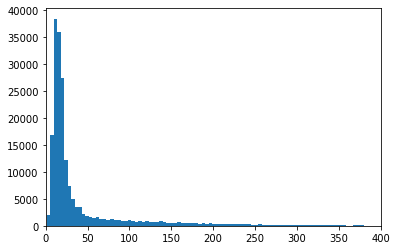

In [12]:
plt.hist(tam, bins = 1800)
plt.xlim(0,400)
plt.show()

In [13]:
longas = [a for a,t in enumerate(tabela.piadas) if len(t.split()) > 30]
curtas = list(set(range(len(tabela.piadas)))-set(longas))

In [14]:
len(longas)/len(tabela.piadas)

0.27916300442552927

In [155]:
print("piadas longas:", tabela.score[longas][np.logical_and(tabela.score > 30, tabela.score < 6000)].mean(),"|",tabela.score[longas][tabela.score > 30].var(),"\n")

print("piadas curtas: ",tabela.score[curtas][np.logical_and(tabela.score > 30, tabela.score < 6000)].mean(),"|",tabela.score[curtas][tabela.score > 30].var())

piadas longas: 385.68477316763546 | 4811204.260022813 

piadas curtas:  306.9642239462371 | 4118639.39724536


In [132]:
piadas_longas = tabela.piadas[longas]
piadas_curtas = tabela.piadas[curtas]

In [16]:
tokens_curtos = [tokens[a] for a in curtas]
tokens_longos = [tokens[a] for a in longas]

In [18]:
dic_curto = corpora.Dictionary(tokens_curtos)
corpus_curto = [dic_curto.doc2bow(piada) for piada in tokens_curtos]
print(dic_curto,"\n")

dic_longo = corpora.Dictionary(tokens_longos)
corpus_longo = [dic_longo.doc2bow(piada) for piada in tokens_longos]
print(dic_longo)

Dictionary(23922 unique tokens: ['anymor', 'black', 'cant', 'even', 'fenc']...) 

Dictionary(28555 unique tokens: ['america', 'american', 'but', 'cultur', 'day']...)


In [19]:
dic = corpora.Dictionary(tokens)
corpus = [dic.doc2bow(piada) for piada in tokens]
print(dic,"\n")

Dictionary(31925 unique tokens: ['anymor', 'black', 'cant', 'even', 'fenc']...) 



In [20]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [24]:
tfidf_longo = models.TfidfModel(corpus_longo)
corpus_tfidf_l = tfidf_longo[corpus_longo]

tfidf_curto = models.TfidfModel(corpus_curto)
corpus_tfidf_c = tfidf_curto[corpus_curto]

In [22]:
lsi = models.LsiModel(corpus_tfidf, id2word=dic, num_topics=9)
corpus_lsi = lsi[corpus_tfidf]

In [25]:
lsi_curto = models.LsiModel(corpus_tfidf_c, id2word=dic_curto, num_topics=9)
corpus_lsi_c = lsi_curto[corpus_tfidf_c]

lsi_longo = models.LsiModel(corpus_tfidf_l, id2word=dic_longo, num_topics=9)
corpus_lsi_l = lsi_longo[corpus_tfidf_l]

In [29]:
data = {i: OrderedDict(lsi.show_topic(i)) for i in range(9)}
data_curto = {i: OrderedDict(lsi_curto.show_topic(i)) for i in range(9)}
data_longo = {i: OrderedDict(lsi_longo.show_topic(i)) for i in range(9)}

In [32]:
df,df_c,df_l = pd.DataFrame(data),pd.DataFrame(data_curto),pd.DataFrame(data_longo)
print(df.shape,df_c.shape,df_l.shape)
df,df_c,df_l = df.fillna(0).T,df_c.fillna(0).T,df_l.fillna(0).T

(43, 9) (38, 9) (37, 9)


### Cluster Map das Piadas

---
Abaixo temos 3 cluster maps, o de todas as piadas, os das piadas curtas e os das piadas longas

----

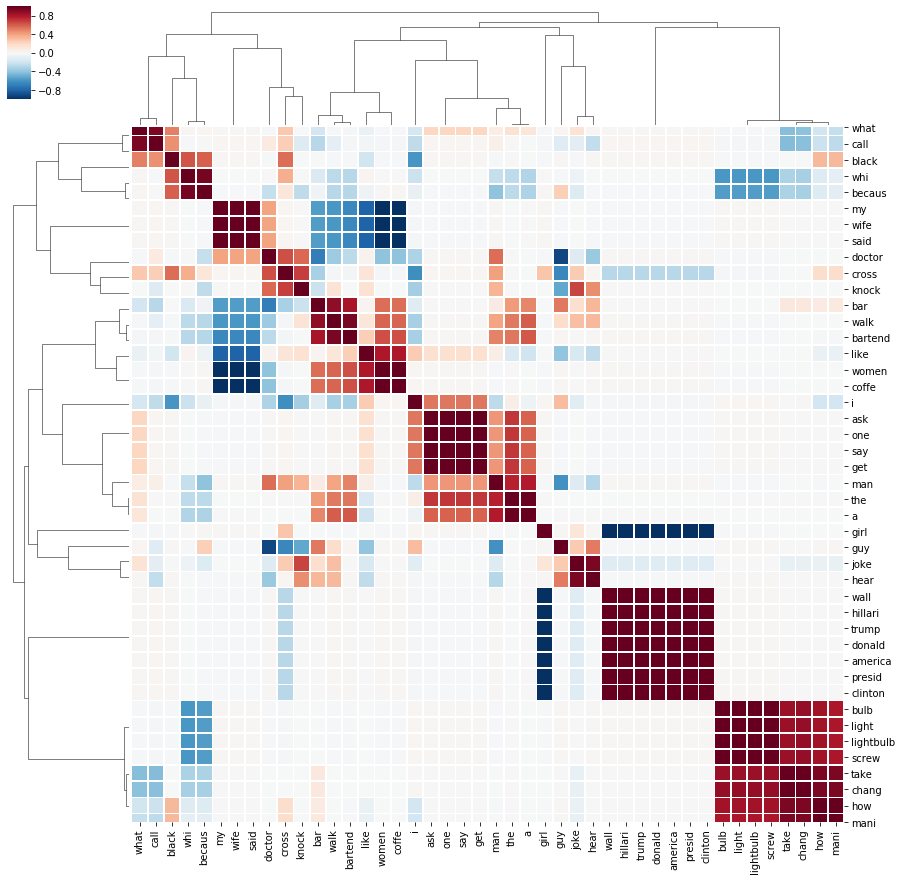

In [159]:
sns.clustermap(df.corr(), center=0, cmap="RdBu_r", metric='cosine',
               linewidths=.75, figsize=(15, 15))
plt.show()

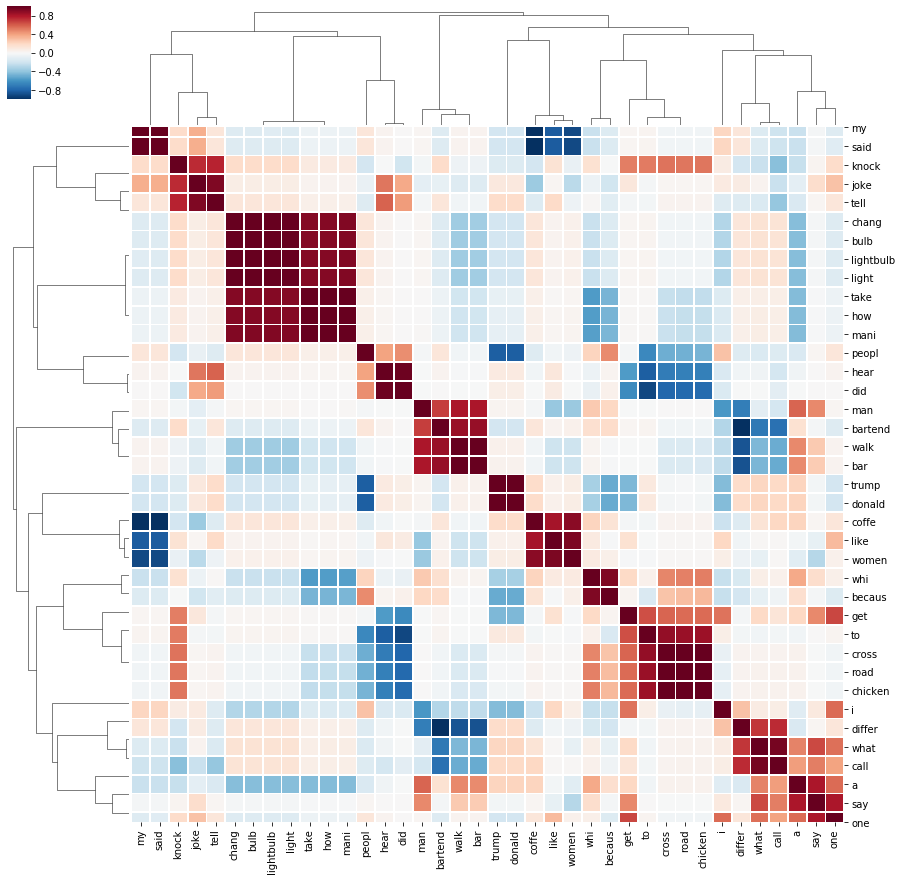

In [33]:
sns.clustermap(df_c.corr(), center=0, cmap="RdBu_r", metric='cosine',
               linewidths=.75, figsize=(15, 15))
plt.show()

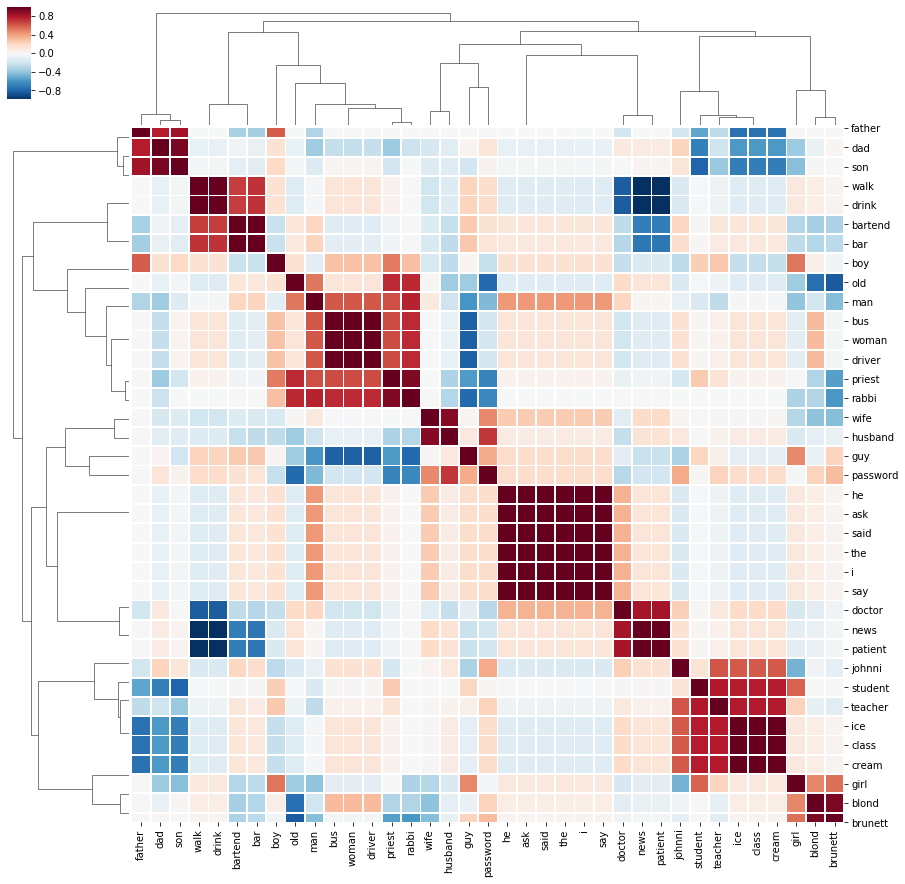

In [34]:
sns.clustermap(df_l.corr(), center=0, cmap="RdBu_r", metric='cosine',
               linewidths=.75, figsize=(15, 15))
plt.show()

In [35]:
index_curto = similarities.MatrixSimilarity(corpus_lsi_c)
index_longo = similarities.MatrixSimilarity(corpus_lsi_l)

In [75]:
sims = index_curto[corpus_lsi_c[3]]
pprint(sorted(list(enumerate(sims)), key=lambda x:x[1], reverse=True))

[(3, 1.0),
 (90830, 0.9994026),
 (56306, 0.9993937),
 (56564, 0.9993627),
 (95286, 0.9992985),
 (119235, 0.99919075),
 (6553, 0.99914944),
 (67935, 0.9991244),
 (107749, 0.99910015),
 (48135, 0.9990827),
 (37374, 0.9990222),
 (50804, 0.9989377),
 (30436, 0.9989189),
 (3269, 0.9988606),
 (60846, 0.9988528),
 (63325, 0.9988073),
 (70929, 0.99879676),
 (10860, 0.9987734),
 (31800, 0.9987474),
 (85215, 0.9987272),
 (19359, 0.998703),
 (59304, 0.99870247),
 (117578, 0.99869883),
 (82817, 0.99869746),
 (92772, 0.99869674),
 (34495, 0.9986347),
 (30192, 0.99863106),
 (53979, 0.9986266),
 (75787, 0.99861515),
 (32840, 0.99860716),
 (7406, 0.9986006),
 (128100, 0.9985906),
 (40230, 0.9985789),
 (80464, 0.9985658),
 (106266, 0.99855363),
 (138240, 0.99854755),
 (20416, 0.99853724),
 (29890, 0.9985158),
 (75975, 0.9985109),
 (4591, 0.9985071),
 (139489, 0.9984975),
 (121645, 0.99848956),
 (45880, 0.9984851),
 (129455, 0.99848074),
 (131056, 0.9984735),
 (137583, 0.9984598),
 (17730, 0.99844265),


 (50716, 0.992713),
 (59978, 0.9927066),
 (7598, 0.99269986),
 (54488, 0.99269986),
 (86418, 0.9926996),
 (76174, 0.992689),
 (89468, 0.9926772),
 (32409, 0.99267316),
 (13480, 0.9926731),
 (46388, 0.9926729),
 (135439, 0.99266094),
 (34682, 0.99265766),
 (39488, 0.9926492),
 (71309, 0.9926444),
 (23539, 0.9926423),
 (83102, 0.9926401),
 (82402, 0.9926309),
 (112615, 0.99262106),
 (35082, 0.9926176),
 (23026, 0.9926175),
 (63604, 0.9926101),
 (66797, 0.9926098),
 (74655, 0.99260944),
 (52446, 0.99258894),
 (46269, 0.99257267),
 (95512, 0.99257267),
 (129159, 0.9925687),
 (84974, 0.9925664),
 (80422, 0.99256605),
 (97499, 0.9925622),
 (135311, 0.9925563),
 (94874, 0.9925487),
 (33010, 0.99254817),
 (119072, 0.99254346),
 (102612, 0.9925424),
 (96724, 0.9925292),
 (99192, 0.9925292),
 (5450, 0.99252725),
 (70401, 0.99252385),
 (51981, 0.9925234),
 (16292, 0.9925158),
 (106969, 0.99251103),
 (27773, 0.9925017),
 (23577, 0.9924955),
 (13084, 0.99249446),
 (97484, 0.99248767),
 (49494, 0.99

 (55275, 0.98216313),
 (131913, 0.98216194),
 (87500, 0.982159),
 (72177, 0.9821522),
 (101569, 0.982136),
 (119242, 0.98211414),
 (102221, 0.9821098),
 (30310, 0.9820905),
 (128588, 0.9820872),
 (139820, 0.9820832),
 (116445, 0.9820652),
 (21515, 0.9820583),
 (110633, 0.98203427),
 (104096, 0.982032),
 (45591, 0.98201185),
 (117016, 0.9820057),
 (51130, 0.9819797),
 (81475, 0.98197734),
 (43498, 0.98196995),
 (115247, 0.98196954),
 (39493, 0.98195606),
 (52888, 0.98195606),
 (65474, 0.98195606),
 (73474, 0.98195606),
 (99513, 0.98195606),
 (112781, 0.98195606),
 (114370, 0.98195606),
 (115905, 0.98195606),
 (41211, 0.9819445),
 (6948, 0.98194313),
 (26876, 0.9819367),
 (60306, 0.98193574),
 (74975, 0.98193574),
 (4034, 0.9819268),
 (134873, 0.9819244),
 (90214, 0.981916),
 (49803, 0.98190707),
 (103179, 0.9819026),
 (2825, 0.9819024),
 (73121, 0.98190093),
 (13771, 0.9818994),
 (42948, 0.98189414),
 (112849, 0.98189116),
 (51098, 0.9818865),
 (94882, 0.98188424),
 (54735, 0.98188376),

 (90190, 0.9635222),
 (80864, 0.9635212),
 (112211, 0.9635188),
 (44233, 0.9635134),
 (55288, 0.96350414),
 (105345, 0.96350306),
 (125398, 0.96350306),
 (70298, 0.9634714),
 (82198, 0.9634673),
 (95048, 0.9634423),
 (45370, 0.96343565),
 (93167, 0.9633994),
 (97086, 0.9633994),
 (116492, 0.9633994),
 (138463, 0.9633994),
 (99205, 0.9633981),
 (114090, 0.9633724),
 (95385, 0.96335804),
 (114446, 0.96334434),
 (40877, 0.9633415),
 (58155, 0.9633324),
 (53528, 0.9633131),
 (49492, 0.9632885),
 (91695, 0.963284),
 (113676, 0.96326375),
 (1090, 0.96324587),
 (13002, 0.96324277),
 (20733, 0.9632237),
 (82282, 0.9632237),
 (112279, 0.9632237),
 (123094, 0.9632237),
 (138421, 0.9632237),
 (33173, 0.9632189),
 (110989, 0.963216),
 (23516, 0.96317613),
 (13870, 0.96315956),
 (11510, 0.963158),
 (15548, 0.963158),
 (64889, 0.963158),
 (115597, 0.963158),
 (134102, 0.963158),
 (93903, 0.9631463),
 (9988, 0.96310735),
 (22630, 0.96310735),
 (104416, 0.963096),
 (26814, 0.9630925),
 (87964, 0.96309

 (133466, 0.94127303),
 (106574, 0.94126123),
 (90556, 0.941239),
 (137612, 0.94121253),
 (75266, 0.9412011),
 (54884, 0.94116485),
 (85707, 0.94114244),
 (42392, 0.9411402),
 (99060, 0.94111884),
 (87358, 0.9411043),
 (94286, 0.9411025),
 (863, 0.9410897),
 (25648, 0.9410815),
 (12680, 0.9410775),
 (132001, 0.94107383),
 (51198, 0.9410721),
 (77130, 0.94106376),
 (56292, 0.9410141),
 (25525, 0.94098675),
 (93476, 0.9409777),
 (66026, 0.94095206),
 (53379, 0.9409366),
 (136345, 0.9409244),
 (107055, 0.94092214),
 (38590, 0.94091815),
 (88038, 0.94090533),
 (59349, 0.9408989),
 (10259, 0.9408969),
 (79887, 0.9408957),
 (133621, 0.94088364),
 (34889, 0.9408775),
 (41593, 0.94086146),
 (56320, 0.9408403),
 (1273, 0.94083905),
 (13477, 0.94083464),
 (16892, 0.94083434),
 (3193, 0.9408185),
 (81108, 0.9408185),
 (91631, 0.9408185),
 (107331, 0.9408185),
 (129456, 0.9408185),
 (138800, 0.9408002),
 (109774, 0.9407963),
 (83948, 0.9407862),
 (53745, 0.9407663),
 (57897, 0.94072413),
 (109133,

 (78492, 0.9021119),
 (55507, 0.9020597),
 (11459, 0.902033),
 (2054, 0.90202254),
 (5176, 0.9019923),
 (7529, 0.9019859),
 (47099, 0.90197307),
 (72089, 0.9019654),
 (66805, 0.90194476),
 (76779, 0.9019324),
 (116089, 0.90192527),
 (83527, 0.9019212),
 (95423, 0.90190375),
 (41044, 0.90187174),
 (85145, 0.90186286),
 (51735, 0.90185153),
 (35747, 0.9018177),
 (9808, 0.9017621),
 (38650, 0.9017445),
 (60139, 0.90172315),
 (81364, 0.9017231),
 (109497, 0.9017211),
 (13794, 0.9017057),
 (44315, 0.9016975),
 (37278, 0.90168387),
 (21965, 0.90164906),
 (28047, 0.90164906),
 (24381, 0.90164006),
 (27846, 0.90163994),
 (109142, 0.9016236),
 (4449, 0.90160507),
 (98170, 0.9015962),
 (44664, 0.90157783),
 (137711, 0.9015036),
 (54220, 0.9014995),
 (83170, 0.901441),
 (135711, 0.9014253),
 (4883, 0.9013948),
 (124692, 0.9013624),
 (15267, 0.901362),
 (78588, 0.9013338),
 (90372, 0.9013181),
 (5954, 0.9012649),
 (76747, 0.90121967),
 (93048, 0.90120465),
 (11614, 0.9011793),
 (60967, 0.9011754),

 (56057, 0.83902377),
 (95540, 0.83897364),
 (131136, 0.83893824),
 (133509, 0.83893824),
 (99743, 0.8389007),
 (140171, 0.8389007),
 (37091, 0.83886003),
 (80804, 0.8387507),
 (127670, 0.8386357),
 (133407, 0.8385825),
 (55067, 0.8385811),
 (127939, 0.8385701),
 (6436, 0.8385676),
 (110488, 0.8384345),
 (75869, 0.838425),
 (85381, 0.83840156),
 (12138, 0.83837545),
 (58016, 0.8383084),
 (56325, 0.8383082),
 (128848, 0.83827376),
 (7766, 0.83818614),
 (117201, 0.8381219),
 (41275, 0.83809423),
 (34775, 0.83803636),
 (46748, 0.8380294),
 (58951, 0.8379206),
 (43682, 0.8378413),
 (129538, 0.8378369),
 (58260, 0.8378287),
 (54799, 0.8378195),
 (13601, 0.83769333),
 (116178, 0.8376893),
 (114142, 0.83768123),
 (40154, 0.8376281),
 (98748, 0.8376216),
 (89689, 0.8375536),
 (104063, 0.8374559),
 (9932, 0.8374259),
 (1633, 0.8372636),
 (18603, 0.8371896),
 (72698, 0.83717877),
 (136019, 0.83714104),
 (526, 0.8371294),
 (17574, 0.8370205),
 (86872, 0.83696836),
 (48656, 0.8368801),
 (23711, 0.

 (40104, 0.7267624),
 (115826, 0.7266636),
 (130790, 0.72649723),
 (58254, 0.7264577),
 (130724, 0.72643083),
 (122980, 0.726401),
 (77556, 0.7263488),
 (74408, 0.72634864),
 (8905, 0.7263156),
 (51137, 0.7262448),
 (138295, 0.7261913),
 (62047, 0.7261531),
 (11748, 0.7260707),
 (56249, 0.7259642),
 (48685, 0.725947),
 (120045, 0.7259041),
 (97796, 0.7257665),
 (139652, 0.7257665),
 (17848, 0.7255852),
 (38715, 0.7255005),
 (116541, 0.72546846),
 (27430, 0.7254394),
 (133667, 0.7253832),
 (47505, 0.7252676),
 (101134, 0.7252354),
 (71483, 0.7252059),
 (71334, 0.72520477),
 (69866, 0.72511375),
 (50015, 0.72501636),
 (17211, 0.72489643),
 (63068, 0.7248851),
 (35162, 0.7248066),
 (110118, 0.7246541),
 (126843, 0.7246369),
 (118881, 0.7246237),
 (136567, 0.7245419),
 (93655, 0.7244657),
 (41069, 0.72439003),
 (20491, 0.72413325),
 (8918, 0.7240958),
 (44602, 0.7240484),
 (54364, 0.72403216),
 (41517, 0.7240081),
 (89880, 0.72396696),
 (27623, 0.72393864),
 (86762, 0.72379005),
 (128769, 

 (10480, 0.61886364),
 (68696, 0.61880994),
 (49962, 0.6187764),
 (85089, 0.6187279),
 (82997, 0.61871517),
 (55124, 0.6186851),
 (24927, 0.6186353),
 (85944, 0.6185737),
 (117358, 0.61855996),
 (137786, 0.6185484),
 (126602, 0.6185249),
 (66732, 0.6185248),
 (37967, 0.61850196),
 (87458, 0.61841273),
 (138754, 0.6184034),
 (95158, 0.618363),
 (129403, 0.6183604),
 (124815, 0.6182798),
 (116613, 0.6182581),
 (51546, 0.61825216),
 (20568, 0.6182138),
 (19356, 0.6181656),
 (20184, 0.61813825),
 (94299, 0.6181203),
 (89223, 0.61796045),
 (115346, 0.61785173),
 (58662, 0.61782634),
 (87361, 0.61779183),
 (54928, 0.61776954),
 (41205, 0.61773586),
 (54688, 0.61772877),
 (96160, 0.61771494),
 (39326, 0.6177053),
 (33396, 0.6176073),
 (115655, 0.6175133),
 (19705, 0.6174404),
 (108489, 0.6174404),
 (112140, 0.61743474),
 (95015, 0.61742973),
 (85613, 0.6173008),
 (88152, 0.6172237),
 (18726, 0.61716914),
 (103277, 0.6171634),
 (15016, 0.6171054),
 (91770, 0.6170382),
 (66261, 0.61703175),
 (1

 (66035, 0.5472346),
 (105747, 0.5472346),
 (110247, 0.5472346),
 (138189, 0.5472346),
 (95788, 0.547221),
 (6492, 0.5471972),
 (72830, 0.5471768),
 (50815, 0.54711974),
 (167, 0.54711),
 (40510, 0.5471012),
 (21949, 0.5470637),
 (28035, 0.5470637),
 (31484, 0.5470637),
 (47756, 0.5470637),
 (114342, 0.5470637),
 (50029, 0.5470557),
 (95229, 0.54702437),
 (101626, 0.5469818),
 (110129, 0.54695743),
 (124847, 0.5469481),
 (121162, 0.54694486),
 (93394, 0.5469353),
 (60420, 0.54691666),
 (94328, 0.54685163),
 (95017, 0.5466291),
 (9256, 0.5466149),
 (41794, 0.5465981),
 (136877, 0.5465961),
 (32299, 0.54658383),
 (87510, 0.54648405),
 (125220, 0.5464815),
 (53350, 0.5464644),
 (136080, 0.54641277),
 (30669, 0.5463772),
 (99049, 0.5463538),
 (79515, 0.5463151),
 (83428, 0.54629886),
 (80220, 0.54625046),
 (103449, 0.5462295),
 (79150, 0.546171),
 (17004, 0.5461552),
 (75813, 0.54615015),
 (52618, 0.5461445),
 (16953, 0.5461162),
 (17635, 0.5461089),
 (68585, 0.5460655),
 (59055, 0.5460638

 (72039, 0.49568808),
 (14292, 0.4956744),
 (68167, 0.49566987),
 (55448, 0.49566197),
 (133294, 0.49562877),
 (55666, 0.49562007),
 (83429, 0.4956054),
 (48595, 0.49559334),
 (61444, 0.49558133),
 (97727, 0.4955635),
 (104969, 0.49554655),
 (45563, 0.49552628),
 (8608, 0.49547997),
 (107133, 0.49547237),
 (57040, 0.4954283),
 (52000, 0.49542785),
 (123931, 0.49541992),
 (18323, 0.49539262),
 (138346, 0.4953857),
 (58936, 0.49533767),
 (7673, 0.4953128),
 (119149, 0.4952903),
 (39060, 0.49528515),
 (60601, 0.49527782),
 (4621, 0.49525574),
 (20744, 0.49525574),
 (37983, 0.49525574),
 (58927, 0.49525574),
 (84927, 0.49525574),
 (85316, 0.49525574),
 (92329, 0.49525574),
 (108252, 0.49525574),
 (114153, 0.49525574),
 (121595, 0.49525574),
 (48278, 0.49524426),
 (106650, 0.49518234),
 (83838, 0.4950891),
 (9404, 0.49505112),
 (61577, 0.49504182),
 (119852, 0.49502313),
 (91002, 0.49500176),
 (33137, 0.49499023),
 (65558, 0.49496204),
 (29995, 0.49495125),
 (128997, 0.4949023),
 (7960, 0.4

 (39933, 0.45545107),
 (6833, 0.45544505),
 (4371, 0.45544097),
 (88606, 0.45541146),
 (63741, 0.4553737),
 (81309, 0.4553705),
 (126228, 0.45535874),
 (113685, 0.45534223),
 (81636, 0.45531228),
 (132190, 0.45529923),
 (44740, 0.45528412),
 (85517, 0.45525017),
 (63351, 0.455234),
 (48770, 0.45522088),
 (131828, 0.45521602),
 (4489, 0.45520657),
 (104288, 0.45518097),
 (97057, 0.45517704),
 (103801, 0.45515573),
 (5775, 0.45515475),
 (108928, 0.4551373),
 (67676, 0.4550679),
 (31328, 0.45505524),
 (43841, 0.45504355),
 (69677, 0.45495144),
 (313, 0.45493525),
 (66815, 0.4549117),
 (89251, 0.4548909),
 (58398, 0.45488262),
 (30677, 0.45486516),
 (87482, 0.4548649),
 (120211, 0.45485836),
 (126724, 0.454858),
 (28463, 0.45485628),
 (23850, 0.4548536),
 (71127, 0.4548422),
 (92657, 0.45482126),
 (3739, 0.4547978),
 (13949, 0.45478415),
 (71437, 0.45477876),
 (38409, 0.45476693),
 (3576, 0.4547578),
 (10043, 0.45473558),
 (114379, 0.45472708),
 (27437, 0.4547193),
 (106821, 0.45470667),
 

 (12937, 0.4239877),
 (128970, 0.42398688),
 (20013, 0.42394608),
 (113239, 0.42393702),
 (28901, 0.42393687),
 (106788, 0.42392352),
 (62419, 0.42389983),
 (54461, 0.423897),
 (79010, 0.42388362),
 (41679, 0.4238618),
 (3057, 0.42385447),
 (51400, 0.4238534),
 (41606, 0.42384124),
 (83460, 0.42383742),
 (99940, 0.42383406),
 (7782, 0.4238184),
 (27191, 0.4237826),
 (83856, 0.42377216),
 (20848, 0.42375988),
 (72917, 0.42373982),
 (100364, 0.4237163),
 (50283, 0.42367572),
 (12129, 0.42367375),
 (134429, 0.42367375),
 (118907, 0.42367053),
 (36028, 0.42366713),
 (23671, 0.42364383),
 (114346, 0.42363104),
 (12142, 0.42362165),
 (36656, 0.42361152),
 (56327, 0.4236021),
 (47485, 0.4235855),
 (81369, 0.42358512),
 (25699, 0.4235808),
 (123725, 0.4235765),
 (118225, 0.4235742),
 (73486, 0.42355937),
 (85029, 0.42354253),
 (26561, 0.4235049),
 (78424, 0.423487),
 (122451, 0.423487),
 (48646, 0.42345396),
 (16852, 0.42344654),
 (130897, 0.42340362),
 (26345, 0.42339393),
 (4848, 0.42334408)

 (69725, 0.40310878),
 (13456, 0.403088),
 (122443, 0.4030817),
 (108727, 0.40308076),
 (74971, 0.403077),
 (6606, 0.4030462),
 (56600, 0.4030458),
 (60587, 0.40304428),
 (72907, 0.40304428),
 (103454, 0.40301755),
 (116449, 0.40301043),
 (31011, 0.40300673),
 (106435, 0.40299907),
 (18232, 0.40299568),
 (21984, 0.40297472),
 (87772, 0.40296233),
 (26360, 0.40291977),
 (139093, 0.40289748),
 (121829, 0.40289593),
 (51343, 0.40289533),
 (109190, 0.40285796),
 (30902, 0.40285414),
 (125065, 0.40285245),
 (132040, 0.4028523),
 (49057, 0.40284848),
 (119860, 0.4027994),
 (8821, 0.40279472),
 (78735, 0.40278918),
 (11847, 0.4027433),
 (13702, 0.40273762),
 (60221, 0.40272206),
 (135522, 0.40272012),
 (105934, 0.40270254),
 (103196, 0.4026568),
 (14837, 0.4026507),
 (12818, 0.40265036),
 (99008, 0.40265036),
 (132983, 0.40264335),
 (51929, 0.40262288),
 (42445, 0.4025858),
 (68836, 0.40258557),
 (5948, 0.40258396),
 (21196, 0.4025564),
 (76817, 0.40255156),
 (18910, 0.40255007),
 (70698, 0.4

 (45501, 0.38276088),
 (49055, 0.38275504),
 (116687, 0.38273796),
 (34385, 0.3827284),
 (2321, 0.38270205),
 (136697, 0.38267696),
 (79287, 0.38267183),
 (104228, 0.38267183),
 (87551, 0.38266012),
 (107998, 0.3825969),
 (112220, 0.38257006),
 (22165, 0.382564),
 (50369, 0.38254994),
 (105042, 0.38254005),
 (68123, 0.3825398),
 (34552, 0.38250816),
 (20150, 0.38250428),
 (89898, 0.38250244),
 (55085, 0.3824736),
 (33767, 0.38246644),
 (129150, 0.3824501),
 (107841, 0.3824493),
 (4975, 0.38244575),
 (71398, 0.3824365),
 (80000, 0.38242862),
 (31893, 0.38242525),
 (85354, 0.38237154),
 (36479, 0.38236833),
 (84747, 0.38236743),
 (37499, 0.38235426),
 (3501, 0.38234842),
 (71016, 0.38233542),
 (130903, 0.38231236),
 (4437, 0.3823105),
 (129369, 0.38230884),
 (126064, 0.38228905),
 (88705, 0.38228506),
 (30989, 0.3822847),
 (86673, 0.38227898),
 (117453, 0.38227868),
 (90495, 0.3822704),
 (38116, 0.38226894),
 (122702, 0.3822569),
 (50079, 0.38225383),
 (112247, 0.38224953),
 (131030, 0.3

 (47432, 0.36706647),
 (41273, 0.3670446),
 (68410, 0.36703452),
 (61044, 0.36702317),
 (133993, 0.36699304),
 (131646, 0.36698723),
 (101978, 0.36698258),
 (115275, 0.36698258),
 (125359, 0.3669777),
 (131459, 0.3669355),
 (90197, 0.36693126),
 (90194, 0.3669275),
 (113033, 0.36689296),
 (23216, 0.36688626),
 (81078, 0.36688626),
 (23073, 0.36688313),
 (91401, 0.36687845),
 (117427, 0.36687636),
 (6925, 0.36685967),
 (78826, 0.36685395),
 (32047, 0.36685145),
 (113418, 0.36682266),
 (57035, 0.3668161),
 (31323, 0.3667962),
 (55433, 0.36679533),
 (14501, 0.36678582),
 (36005, 0.3667755),
 (7885, 0.3667747),
 (86636, 0.36674693),
 (95880, 0.36674577),
 (10548, 0.36674327),
 (101098, 0.36671826),
 (5751, 0.3667106),
 (85823, 0.36670807),
 (2259, 0.36670208),
 (93453, 0.3666968),
 (124455, 0.36669594),
 (123907, 0.36668396),
 (125968, 0.3666794),
 (6817, 0.36666876),
 (6827, 0.36666876),
 (9596, 0.36666626),
 (8578, 0.36666262),
 (77693, 0.36666262),
 (101139, 0.36666262),
 (79265, 0.3666

 (112848, 0.3472305),
 (110570, 0.3472293),
 (101284, 0.3472265),
 (58901, 0.34722304),
 (110853, 0.34722003),
 (5563, 0.34721893),
 (120294, 0.347217),
 (10752, 0.34721285),
 (115091, 0.3471961),
 (94209, 0.34716696),
 (78978, 0.34716156),
 (63249, 0.34714586),
 (1641, 0.34714407),
 (4117, 0.34714407),
 (27255, 0.34713864),
 (64689, 0.3471326),
 (58050, 0.34711194),
 (23265, 0.34710994),
 (23492, 0.34709656),
 (88631, 0.3470941),
 (108249, 0.3470886),
 (99499, 0.34708804),
 (61289, 0.3470618),
 (25540, 0.34705988),
 (133974, 0.34705687),
 (117759, 0.3470555),
 (8640, 0.34705198),
 (111263, 0.34704322),
 (110042, 0.34704238),
 (112053, 0.34703588),
 (60855, 0.34702945),
 (120697, 0.34702396),
 (1330, 0.34700978),
 (96106, 0.34700978),
 (68681, 0.34700426),
 (34746, 0.34700352),
 (98162, 0.34699023),
 (130993, 0.34697163),
 (139564, 0.34695536),
 (97616, 0.34694868),
 (22158, 0.34693736),
 (103017, 0.3469344),
 (110498, 0.34693345),
 (108609, 0.3469242),
 (115191, 0.34692144),
 (14035, 

 (73740, 0.33073324),
 (83108, 0.33070752),
 (102269, 0.33070552),
 (41797, 0.33070022),
 (56894, 0.33069098),
 (11352, 0.33067185),
 (140009, 0.3306709),
 (99266, 0.3306514),
 (58018, 0.33065015),
 (77115, 0.33064818),
 (63004, 0.3306115),
 (69275, 0.3305884),
 (42305, 0.33058834),
 (63385, 0.33058834),
 (103510, 0.33058834),
 (13928, 0.3305822),
 (29364, 0.33056903),
 (28902, 0.33056402),
 (65492, 0.33055347),
 (978, 0.3305456),
 (60847, 0.3305328),
 (112201, 0.3305325),
 (68177, 0.3305207),
 (85344, 0.33050728),
 (61209, 0.3305067),
 (96207, 0.33049783),
 (6359, 0.33048856),
 (28728, 0.3304835),
 (24674, 0.3304816),
 (64457, 0.33046502),
 (118438, 0.330463),
 (39323, 0.33043396),
 (75737, 0.33040965),
 (84825, 0.33040446),
 (116788, 0.33039105),
 (125363, 0.3303747),
 (135291, 0.33036938),
 (110892, 0.33036488),
 (55528, 0.33036077),
 (132673, 0.33035988),
 (113406, 0.33035958),
 (58619, 0.33032545),
 (21406, 0.33032215),
 (39743, 0.3303192),
 (127375, 0.33031237),
 (37784, 0.330293

 (106050, 0.31531453),
 (22627, 0.3153103),
 (124582, 0.3153065),
 (84064, 0.31529728),
 (48992, 0.3152944),
 (133071, 0.31529075),
 (79408, 0.31527597),
 (56356, 0.31526062),
 (69397, 0.31525317),
 (21064, 0.31522128),
 (52255, 0.3151989),
 (42275, 0.3151846),
 (64072, 0.31517315),
 (121905, 0.3151666),
 (26947, 0.31516242),
 (4787, 0.3151547),
 (125548, 0.31513923),
 (3950, 0.3151247),
 (39416, 0.3151247),
 (134305, 0.31511107),
 (61493, 0.31510758),
 (49041, 0.3151008),
 (110070, 0.3150834),
 (130228, 0.31506357),
 (63996, 0.31505004),
 (93840, 0.3150491),
 (134426, 0.31504214),
 (83791, 0.31502062),
 (86062, 0.31501707),
 (38764, 0.31500316),
 (108789, 0.31498298),
 (57976, 0.3149754),
 (39167, 0.3149618),
 (56910, 0.31495732),
 (95952, 0.31495476),
 (16034, 0.31494975),
 (91051, 0.31493527),
 (118977, 0.31490004),
 (71560, 0.31489775),
 (138657, 0.31489775),
 (73938, 0.31487823),
 (19476, 0.31487727),
 (115266, 0.31487042),
 (100707, 0.31486797),
 (41759, 0.31486234),
 (113891, 0.

 (112078, 0.2980407),
 (87371, 0.29803687),
 (12973, 0.298009),
 (78881, 0.29800838),
 (84392, 0.29800496),
 (42474, 0.297994),
 (11476, 0.29798383),
 (116735, 0.2979837),
 (55336, 0.29797864),
 (64607, 0.2979736),
 (64363, 0.29797056),
 (79421, 0.29797056),
 (81287, 0.29797056),
 (96421, 0.29797056),
 (122854, 0.29797056),
 (136163, 0.29797056),
 (1579, 0.29796267),
 (125501, 0.29793745),
 (95210, 0.2979367),
 (135074, 0.2979306),
 (2606, 0.29792506),
 (118606, 0.2979218),
 (6599, 0.29791084),
 (12792, 0.29791084),
 (112704, 0.2979037),
 (100807, 0.29787967),
 (6947, 0.29787925),
 (26216, 0.29785696),
 (132395, 0.29784888),
 (46609, 0.2978344),
 (57017, 0.29783177),
 (50739, 0.2978263),
 (42504, 0.29782173),
 (66740, 0.29781777),
 (44979, 0.2978173),
 (84803, 0.29780972),
 (7351, 0.29776493),
 (89356, 0.29775608),
 (85618, 0.29775187),
 (110622, 0.29774606),
 (90788, 0.2977353),
 (56994, 0.29773),
 (81182, 0.2977292),
 (121490, 0.2977286),
 (61279, 0.29771355),
 (31959, 0.29768342),
 

 (127764, 0.28429267),
 (33460, 0.28429145),
 (64705, 0.2842789),
 (25398, 0.2842775),
 (113025, 0.28426936),
 (66953, 0.28426272),
 (51414, 0.28425694),
 (132889, 0.28425616),
 (23456, 0.28423634),
 (65464, 0.28421307),
 (78813, 0.2842047),
 (43828, 0.28419852),
 (122338, 0.28419828),
 (6112, 0.28418916),
 (97205, 0.28418916),
 (105103, 0.28418916),
 (8315, 0.2841858),
 (131589, 0.28418556),
 (123232, 0.28417015),
 (76073, 0.28416443),
 (3971, 0.28415757),
 (86755, 0.28413558),
 (18436, 0.28413212),
 (54179, 0.2841321),
 (58511, 0.28412235),
 (4383, 0.28411603),
 (60066, 0.28409994),
 (37649, 0.28409845),
 (87549, 0.28409562),
 (120283, 0.28409472),
 (48360, 0.2840913),
 (49364, 0.28408396),
 (13207, 0.28408098),
 (36528, 0.28406718),
 (56334, 0.28404224),
 (94042, 0.28403926),
 (69403, 0.28401527),
 (35059, 0.28400618),
 (27992, 0.28399086),
 (109484, 0.283979),
 (85791, 0.28396997),
 (108770, 0.28396392),
 (129692, 0.28393346),
 (138588, 0.2839327),
 (78303, 0.2839306),
 (93517, 0.2

 (93926, 0.26923192),
 (96099, 0.26923037),
 (133789, 0.26923),
 (25867, 0.26920655),
 (108632, 0.26919642),
 (91902, 0.26917145),
 (44851, 0.26916853),
 (103132, 0.2691664),
 (51979, 0.26916248),
 (136446, 0.26915133),
 (87154, 0.26914248),
 (112792, 0.26914248),
 (40514, 0.26913255),
 (129360, 0.26909724),
 (106542, 0.26908267),
 (81499, 0.26906103),
 (83184, 0.26904905),
 (76771, 0.26904488),
 (79673, 0.26901597),
 (129621, 0.26899955),
 (65376, 0.26899523),
 (29060, 0.26899186),
 (23724, 0.26899183),
 (85075, 0.26897672),
 (113826, 0.26897448),
 (20760, 0.26897386),
 (117298, 0.26893425),
 (101153, 0.26893374),
 (33913, 0.268924),
 (20543, 0.26891437),
 (63143, 0.2689108),
 (116892, 0.26887134),
 (76054, 0.26886445),
 (100597, 0.2688617),
 (119145, 0.26881963),
 (9283, 0.26881534),
 (126805, 0.26879653),
 (58052, 0.26879367),
 (95957, 0.26879218),
 (2415, 0.26877806),
 (139425, 0.2687686),
 (60629, 0.2687388),
 (65606, 0.26873463),
 (32426, 0.2687313),
 (7739, 0.268731),
 (78647, 0

 (94134, 0.25489724),
 (2560, 0.25489008),
 (6710, 0.25488144),
 (135371, 0.25487667),
 (45705, 0.25487438),
 (130015, 0.2548555),
 (77983, 0.2548492),
 (20955, 0.25483996),
 (83993, 0.2548285),
 (136778, 0.25482062),
 (35116, 0.25480777),
 (22990, 0.25480047),
 (55918, 0.25480014),
 (30075, 0.25479504),
 (66911, 0.2547896),
 (129685, 0.25478947),
 (89947, 0.25477892),
 (34348, 0.25477856),
 (9357, 0.25476792),
 (45263, 0.254712),
 (132548, 0.25470397),
 (94193, 0.25470138),
 (80294, 0.25468463),
 (133001, 0.25467926),
 (27918, 0.25467902),
 (66037, 0.2546738),
 (104505, 0.25467283),
 (11986, 0.25466847),
 (97561, 0.25466287),
 (124350, 0.25465706),
 (81476, 0.25465032),
 (77098, 0.25463945),
 (119151, 0.25463474),
 (34514, 0.2546239),
 (62158, 0.25461686),
 (2732, 0.25459427),
 (48811, 0.2545936),
 (745, 0.2545765),
 (53456, 0.2545693),
 (61468, 0.25456697),
 (82031, 0.25456697),
 (100053, 0.25456697),
 (116734, 0.25456697),
 (40400, 0.25456625),
 (57882, 0.25456476),
 (93703, 0.25455

 (63694, 0.24207151),
 (23976, 0.24206659),
 (9112, 0.24204838),
 (4023, 0.24204397),
 (126931, 0.24204195),
 (86379, 0.24202082),
 (66224, 0.24201575),
 (27272, 0.24201512),
 (56798, 0.2420133),
 (112527, 0.24201056),
 (11661, 0.24200292),
 (119295, 0.24200292),
 (65677, 0.24200025),
 (40617, 0.24199933),
 (40229, 0.24198532),
 (136961, 0.2419825),
 (6628, 0.2419759),
 (138279, 0.24197406),
 (45667, 0.24196619),
 (93112, 0.24195433),
 (116555, 0.24195117),
 (46472, 0.24193375),
 (122415, 0.24192436),
 (140136, 0.2419234),
 (106476, 0.24191737),
 (39501, 0.24191268),
 (71505, 0.24190347),
 (6261, 0.24189192),
 (126590, 0.24189189),
 (50722, 0.24187925),
 (132034, 0.24187815),
 (138912, 0.2418718),
 (72008, 0.24186626),
 (110646, 0.24185649),
 (75013, 0.24185248),
 (140028, 0.2418462),
 (112154, 0.24184048),
 (97011, 0.24179053),
 (33965, 0.24177954),
 (119606, 0.24175413),
 (27265, 0.24175207),
 (111459, 0.24175139),
 (89342, 0.2417379),
 (67826, 0.24173704),
 (40623, 0.24173257),
 (54

 (131080, 0.227151),
 (83974, 0.22713959),
 (39739, 0.2271392),
 (109928, 0.22712544),
 (122705, 0.2271235),
 (126260, 0.22712243),
 (1503, 0.22711584),
 (23880, 0.2271107),
 (10555, 0.22710067),
 (15367, 0.22710067),
 (28024, 0.22710067),
 (17696, 0.22709513),
 (15666, 0.22707254),
 (122759, 0.22706978),
 (69197, 0.22706713),
 (84773, 0.227067),
 (111288, 0.22705574),
 (74928, 0.22705394),
 (37640, 0.22704175),
 (102341, 0.22703548),
 (110770, 0.2270152),
 (75992, 0.22701028),
 (109490, 0.22700599),
 (15440, 0.22699824),
 (64989, 0.22699115),
 (105360, 0.22698762),
 (123785, 0.22696328),
 (88871, 0.22696301),
 (18796, 0.2269582),
 (95590, 0.22695218),
 (99119, 0.22694907),
 (139260, 0.22694632),
 (25538, 0.2269446),
 (25616, 0.22693908),
 (91339, 0.2269308),
 (5703, 0.22692502),
 (16542, 0.22692502),
 (17948, 0.22692502),
 (18977, 0.22692502),
 (36930, 0.22692502),
 (37592, 0.22692502),
 (40586, 0.22692502),
 (12325, 0.22692184),
 (82502, 0.2269127),
 (89388, 0.22690955),
 (102601, 0.

 (51759, 0.21627918),
 (139704, 0.2162754),
 (130140, 0.21623975),
 (38217, 0.21623453),
 (78298, 0.21618757),
 (94264, 0.21618384),
 (131302, 0.21618244),
 (49106, 0.21616773),
 (111725, 0.21616611),
 (123257, 0.21614996),
 (78520, 0.21613605),
 (57037, 0.21611486),
 (120199, 0.2161148),
 (4196, 0.21611464),
 (96525, 0.21611416),
 (106195, 0.2161091),
 (134697, 0.21609603),
 (130119, 0.21609007),
 (130396, 0.21608928),
 (90925, 0.21608631),
 (110706, 0.21607342),
 (113712, 0.21606436),
 (51595, 0.21606132),
 (113687, 0.21606025),
 (10657, 0.2160577),
 (115535, 0.2160577),
 (134634, 0.2160577),
 (125563, 0.21604161),
 (25853, 0.21603918),
 (109166, 0.21603751),
 (74496, 0.21603242),
 (52087, 0.21601933),
 (98521, 0.21601754),
 (35070, 0.21601234),
 (136061, 0.21601234),
 (139853, 0.21601234),
 (140203, 0.21599703),
 (41172, 0.21599463),
 (95242, 0.21599413),
 (62704, 0.21599235),
 (95797, 0.21598902),
 (66216, 0.21597648),
 (47268, 0.21597323),
 (65468, 0.21597168),
 (61660, 0.21597144

 (66866, 0.20459643),
 (115783, 0.20459206),
 (22255, 0.20458917),
 (7587, 0.20458163),
 (129109, 0.2045736),
 (92057, 0.20457318),
 (61853, 0.20456734),
 (22327, 0.20456478),
 (123342, 0.20455791),
 (130052, 0.20455536),
 (60470, 0.20455441),
 (58608, 0.20454156),
 (84121, 0.20453998),
 (39656, 0.20453806),
 (127966, 0.20452969),
 (2497, 0.20451513),
 (136265, 0.2045081),
 (65867, 0.20449674),
 (53802, 0.20449585),
 (63605, 0.20449567),
 (101720, 0.2044945),
 (121039, 0.20449214),
 (80622, 0.20448728),
 (10815, 0.2044866),
 (33178, 0.2044866),
 (88481, 0.2044866),
 (107994, 0.2044866),
 (133460, 0.2044866),
 (12462, 0.20448518),
 (5549, 0.20448458),
 (114621, 0.20446673),
 (69280, 0.20445287),
 (84136, 0.20445287),
 (110370, 0.20445287),
 (134554, 0.20445228),
 (576, 0.20445019),
 (134661, 0.20444773),
 (137562, 0.20444676),
 (73604, 0.20443355),
 (134182, 0.20443317),
 (38334, 0.20442629),
 (84658, 0.20441982),
 (48188, 0.20441677),
 (34865, 0.20440449),
 (75118, 0.20440352),
 (12444

 (61824, 0.19317092),
 (3329, 0.19316353),
 (113457, 0.19316325),
 (88521, 0.19316319),
 (89769, 0.1931599),
 (13518, 0.1931583),
 (90229, 0.19315794),
 (83262, 0.19315615),
 (58461, 0.19312707),
 (63352, 0.19312707),
 (93458, 0.19312358),
 (1073, 0.19311716),
 (31904, 0.19310756),
 (139877, 0.19310613),
 (47710, 0.19309981),
 (117913, 0.19309306),
 (32056, 0.19309163),
 (111365, 0.19308661),
 (37997, 0.19307919),
 (74698, 0.19307508),
 (50594, 0.19306804),
 (136010, 0.19306691),
 (19617, 0.19305333),
 (97448, 0.1930433),
 (78425, 0.19304244),
 (17093, 0.19304147),
 (123908, 0.19304048),
 (134752, 0.19303991),
 (100023, 0.19303092),
 (34456, 0.1930236),
 (25401, 0.19302177),
 (6269, 0.19301888),
 (75134, 0.19301003),
 (75508, 0.19300954),
 (35354, 0.19300558),
 (79071, 0.19300558),
 (95704, 0.19300558),
 (109417, 0.19300558),
 (111124, 0.19300558),
 (124110, 0.19300558),
 (2703, 0.19300473),
 (90657, 0.19300093),
 (34074, 0.19297506),
 (118285, 0.19296056),
 (128175, 0.19296037),
 (673

 (121510, 0.18173124),
 (110406, 0.18172741),
 (18141, 0.18172327),
 (21258, 0.18171678),
 (17543, 0.18171194),
 (129473, 0.1817117),
 (45692, 0.18169048),
 (97809, 0.1816884),
 (126596, 0.18167475),
 (117645, 0.18167469),
 (17619, 0.18167323),
 (31151, 0.18167053),
 (19627, 0.18166824),
 (63090, 0.18166068),
 (124597, 0.18165866),
 (75539, 0.18165681),
 (106024, 0.18165432),
 (47628, 0.18163574),
 (59458, 0.18163204),
 (26579, 0.18162847),
 (77854, 0.1816278),
 (18872, 0.18162642),
 (71140, 0.18161705),
 (108637, 0.18160592),
 (138387, 0.18160091),
 (10676, 0.18159704),
 (31615, 0.18159279),
 (111287, 0.18159139),
 (43273, 0.18159083),
 (133008, 0.18157043),
 (21167, 0.18156524),
 (35185, 0.18156524),
 (128443, 0.18156524),
 (114586, 0.18156058),
 (118819, 0.18154685),
 (123989, 0.18154642),
 (85957, 0.18154141),
 (6549, 0.18152921),
 (31350, 0.18152282),
 (51324, 0.1815208),
 (89440, 0.1815178),
 (54984, 0.18151698),
 (91563, 0.18150485),
 (44042, 0.1815038),
 (19121, 0.1815014),
 (2

 (89895, 0.17150563),
 (113430, 0.17149404),
 (105144, 0.1714887),
 (104771, 0.17148498),
 (34192, 0.17147234),
 (94452, 0.17146096),
 (48657, 0.17144895),
 (139897, 0.17144687),
 (97876, 0.17143866),
 (3544, 0.17143515),
 (134136, 0.1714314),
 (80623, 0.1714249),
 (135430, 0.17141865),
 (87641, 0.1714122),
 (138014, 0.17141014),
 (57140, 0.17138807),
 (84094, 0.171381),
 (140064, 0.17138056),
 (45767, 0.17137463),
 (119040, 0.17136574),
 (29653, 0.17135899),
 (111883, 0.17135325),
 (63997, 0.17135264),
 (91388, 0.17135105),
 (95637, 0.17134735),
 (75383, 0.17134461),
 (75967, 0.17134367),
 (71974, 0.17134231),
 (104298, 0.17133602),
 (81398, 0.17133439),
 (92150, 0.17131767),
 (17505, 0.17131501),
 (39301, 0.17130911),
 (39208, 0.17130758),
 (80269, 0.17130448),
 (102577, 0.17130178),
 (116110, 0.17129834),
 (119261, 0.17129794),
 (2647, 0.17129287),
 (105146, 0.17127232),
 (104153, 0.17127076),
 (72898, 0.17127034),
 (83754, 0.17125905),
 (85624, 0.1712578),
 (94152, 0.1712578),
 (11

 (67214, 0.16111195),
 (81410, 0.16111195),
 (47205, 0.1611079),
 (43139, 0.16110721),
 (26, 0.16109747),
 (39017, 0.16107644),
 (55422, 0.1610731),
 (91353, 0.16106763),
 (108921, 0.16106611),
 (131423, 0.16105786),
 (65815, 0.16104622),
 (108500, 0.16104572),
 (37763, 0.16103706),
 (69083, 0.16103193),
 (31778, 0.16101846),
 (94652, 0.161013),
 (61480, 0.16100837),
 (47134, 0.16100007),
 (110797, 0.16099635),
 (82206, 0.1609942),
 (95562, 0.16099364),
 (15335, 0.16098893),
 (20251, 0.16098748),
 (60408, 0.160974),
 (23402, 0.1609707),
 (40292, 0.16096741),
 (82538, 0.16095448),
 (86336, 0.16095288),
 (30714, 0.16094702),
 (63882, 0.16094454),
 (70011, 0.16094151),
 (114407, 0.16093914),
 (80919, 0.16092442),
 (6079, 0.16092366),
 (68029, 0.16092171),
 (51289, 0.16091582),
 (82428, 0.16091451),
 (82796, 0.1609137),
 (21060, 0.16090423),
 (3533, 0.16089162),
 (47940, 0.16089162),
 (57512, 0.16089162),
 (90274, 0.16089162),
 (105220, 0.16089162),
 (134623, 0.16089162),
 (137422, 0.16089

 (75533, 0.15135878),
 (90632, 0.15135652),
 (31136, 0.15135412),
 (72617, 0.15134986),
 (133849, 0.15133438),
 (95182, 0.15132803),
 (52450, 0.1513223),
 (77839, 0.1513093),
 (116474, 0.15130141),
 (36758, 0.1513013),
 (84036, 0.15129413),
 (96486, 0.15127115),
 (99603, 0.15126723),
 (99413, 0.15126207),
 (100762, 0.15124546),
 (131074, 0.15123823),
 (136511, 0.15123089),
 (129481, 0.15122288),
 (71634, 0.15121427),
 (29697, 0.1511951),
 (67510, 0.15118115),
 (137705, 0.15118073),
 (16628, 0.1511749),
 (36063, 0.15117472),
 (139641, 0.15116924),
 (62227, 0.15116903),
 (89594, 0.15116873),
 (114248, 0.15116341),
 (60340, 0.15116258),
 (58443, 0.15116146),
 (68172, 0.15115392),
 (80337, 0.15115197),
 (18039, 0.15114883),
 (25144, 0.15114082),
 (138297, 0.15112805),
 (19367, 0.15112081),
 (11862, 0.15111439),
 (123887, 0.15111412),
 (117901, 0.15111354),
 (131935, 0.15109974),
 (92021, 0.15109071),
 (38293, 0.15109019),
 (116053, 0.15108496),
 (37178, 0.15108481),
 (45695, 0.15108424),
 

 (77480, 0.14147733),
 (44530, 0.1414708),
 (27626, 0.14146778),
 (105525, 0.14146474),
 (19965, 0.14146304),
 (97498, 0.14146022),
 (33089, 0.14146005),
 (121958, 0.14144403),
 (5071, 0.14143738),
 (17147, 0.14143491),
 (41815, 0.14143449),
 (138438, 0.14143082),
 (24291, 0.14142737),
 (14577, 0.14141741),
 (15653, 0.14141624),
 (131986, 0.14141624),
 (92353, 0.14140818),
 (317, 0.1414018),
 (5395, 0.14139448),
 (112741, 0.14139171),
 (55965, 0.1413878),
 (6920, 0.14138427),
 (11640, 0.14136034),
 (8825, 0.14135344),
 (96323, 0.14135301),
 (20157, 0.14132182),
 (29562, 0.14131384),
 (16970, 0.14130552),
 (29745, 0.14130321),
 (50546, 0.14130226),
 (29557, 0.14129214),
 (69587, 0.14127035),
 (123303, 0.14126657),
 (49654, 0.14126),
 (56886, 0.14124735),
 (114887, 0.14124599),
 (34798, 0.14124504),
 (135299, 0.14124155),
 (28018, 0.14123946),
 (126619, 0.1412367),
 (11925, 0.14122412),
 (92833, 0.14121675),
 (44470, 0.14121094),
 (87527, 0.14120603),
 (116715, 0.14120544),
 (32953, 0.14

 (131434, 0.13096294),
 (19633, 0.13095751),
 (33206, 0.13095057),
 (35870, 0.13094783),
 (126855, 0.13094199),
 (9365, 0.13094006),
 (50319, 0.13093977),
 (79586, 0.13093863),
 (30124, 0.13093731),
 (30991, 0.13093412),
 (71841, 0.13093267),
 (30327, 0.13092971),
 (21901, 0.1309283),
 (136441, 0.1309281),
 (26591, 0.13091707),
 (109400, 0.13090958),
 (24961, 0.13090733),
 (133342, 0.13090509),
 (10204, 0.1308946),
 (41911, 0.13087991),
 (11604, 0.13087922),
 (100416, 0.13086352),
 (40932, 0.13085775),
 (133182, 0.13085715),
 (78008, 0.13085487),
 (88487, 0.13084131),
 (7802, 0.13083991),
 (60756, 0.13083945),
 (129806, 0.1308286),
 (64552, 0.13082683),
 (40241, 0.13081482),
 (100126, 0.13081399),
 (21240, 0.13081118),
 (335, 0.13079968),
 (12457, 0.13079855),
 (28994, 0.13079855),
 (46179, 0.13079855),
 (7945, 0.13079524),
 (73039, 0.13077416),
 (139493, 0.13077176),
 (15476, 0.13075098),
 (98599, 0.13073575),
 (29076, 0.13072728),
 (10767, 0.1307225),
 (39028, 0.13071254),
 (56445, 0

 (86909, 0.12260139),
 (77602, 0.122594535),
 (131567, 0.12258673),
 (95596, 0.12258105),
 (96962, 0.12257996),
 (60200, 0.1225792),
 (70830, 0.12257417),
 (15358, 0.12257102),
 (84166, 0.12257087),
 (133197, 0.12254706),
 (127689, 0.12254062),
 (21282, 0.12253052),
 (129563, 0.12251819),
 (128758, 0.12251817),
 (78967, 0.12251525),
 (129201, 0.122508034),
 (41472, 0.1225015),
 (133921, 0.12249841),
 (31065, 0.12249301),
 (36667, 0.12249301),
 (9945, 0.12248932),
 (34360, 0.122481115),
 (101791, 0.122473024),
 (7125, 0.12246818),
 (6727, 0.12246764),
 (18205, 0.122467324),
 (107197, 0.12246142),
 (37586, 0.12245878),
 (127152, 0.1224543),
 (129682, 0.12244739),
 (96911, 0.12244344),
 (93031, 0.122442774),
 (42702, 0.12244032),
 (139279, 0.12243502),
 (7573, 0.1224129),
 (66876, 0.12240973),
 (60904, 0.122402206),
 (19317, 0.122401446),
 (19905, 0.12239714),
 (94110, 0.12239388),
 (129202, 0.12239242),
 (84549, 0.12239095),
 (117138, 0.12238921),
 (44677, 0.12238646),
 (16217, 0.1223848

 (113116, 0.11390689),
 (104997, 0.11390506),
 (21351, 0.11390165),
 (77672, 0.11389971),
 (78222, 0.113884546),
 (10814, 0.11386399),
 (46306, 0.1138377),
 (24407, 0.1138282),
 (94625, 0.11382439),
 (9921, 0.11382325),
 (77509, 0.113808185),
 (90217, 0.113806486),
 (105589, 0.11379582),
 (101670, 0.11379564),
 (41662, 0.11379041),
 (89652, 0.11378778),
 (96757, 0.113785386),
 (96476, 0.11378007),
 (117552, 0.11377345),
 (105156, 0.11375809),
 (139166, 0.113757774),
 (107740, 0.1137565),
 (60988, 0.113755986),
 (82362, 0.11374697),
 (39593, 0.11374565),
 (57072, 0.11374343),
 (78571, 0.11374331),
 (54262, 0.11374173),
 (135825, 0.11374073),
 (70648, 0.11373767),
 (57250, 0.11372928),
 (24041, 0.113720894),
 (117697, 0.113720894),
 (34859, 0.11371179),
 (30728, 0.11370126),
 (67607, 0.11369513),
 (5683, 0.11368853),
 (76956, 0.113682136),
 (88119, 0.11367953),
 (50559, 0.113671735),
 (114552, 0.11366911),
 (115116, 0.11366741),
 (109205, 0.11366357),
 (75817, 0.11365378),
 (50557, 0.113

 (110442, 0.105609216),
 (126837, 0.10560676),
 (14468, 0.105604485),
 (99850, 0.105600275),
 (54994, 0.105597705),
 (98078, 0.10559097),
 (26721, 0.10557794),
 (125750, 0.10556246),
 (48938, 0.10555286),
 (127700, 0.10553971),
 (105776, 0.10553424),
 (108040, 0.10552557),
 (34289, 0.10551993),
 (75934, 0.10549696),
 (30750, 0.10549644),
 (108794, 0.105490476),
 (54390, 0.10548628),
 (101514, 0.10545534),
 (13756, 0.10545093),
 (128469, 0.10544865),
 (92253, 0.10544363),
 (65484, 0.10544279),
 (98139, 0.105441086),
 (94404, 0.10543452),
 (25956, 0.1054341),
 (15835, 0.10543324),
 (68718, 0.10542224),
 (118183, 0.10542202),
 (50171, 0.10542104),
 (131671, 0.10540779),
 (51427, 0.10540503),
 (9833, 0.105402805),
 (48139, 0.10540147),
 (35998, 0.10540094),
 (134810, 0.10539042),
 (49783, 0.10538714),
 (29675, 0.105385944),
 (98428, 0.105385944),
 (12604, 0.10538234),
 (58, 0.10538154),
 (105975, 0.10537723),
 (136559, 0.10536854),
 (37896, 0.105365604),
 (105985, 0.10535607),
 (47795, 0.1

 (109611, 0.097047165),
 (15789, 0.09703331),
 (120357, 0.097031735),
 (116717, 0.09702954),
 (67558, 0.09702418),
 (48090, 0.097021416),
 (99547, 0.09701903),
 (92868, 0.09700729),
 (124604, 0.09700357),
 (14566, 0.09700148),
 (24159, 0.09699415),
 (6467, 0.096985415),
 (72477, 0.09698092),
 (48396, 0.09698053),
 (71028, 0.09698039),
 (139705, 0.09697975),
 (20325, 0.096978076),
 (116052, 0.09697755),
 (57252, 0.096977495),
 (3395, 0.09697344),
 (104412, 0.09696987),
 (79481, 0.0969664),
 (106506, 0.09696228),
 (10385, 0.09696169),
 (101480, 0.09695436),
 (28031, 0.09695196),
 (109540, 0.09694951),
 (105919, 0.096945606),
 (65979, 0.09694324),
 (118913, 0.096940435),
 (124935, 0.09693925),
 (98557, 0.09693581),
 (28127, 0.096932605),
 (33428, 0.09693214),
 (76612, 0.09693168),
 (97411, 0.09692564),
 (72371, 0.0969215),
 (8723, 0.09692005),
 (58429, 0.09691833),
 (109110, 0.09691766),
 (24153, 0.09691049),
 (119230, 0.09690894),
 (6735, 0.09690741),
 (52436, 0.09689896),
 (56534, 0.096

 (94279, 0.088578425),
 (85451, 0.08857528),
 (36506, 0.08857092),
 (122860, 0.08856118),
 (34910, 0.088547125),
 (10087, 0.08854164),
 (42482, 0.08853709),
 (127625, 0.08853038),
 (33477, 0.08852807),
 (47055, 0.08852807),
 (49873, 0.08852807),
 (123239, 0.08852807),
 (129859, 0.08852807),
 (41646, 0.08852625),
 (90798, 0.08852577),
 (34871, 0.08852261),
 (11857, 0.088509314),
 (116258, 0.088509314),
 (118052, 0.08850758),
 (77345, 0.088503405),
 (107467, 0.08849882),
 (55568, 0.08849568),
 (79704, 0.08849184),
 (37108, 0.08848931),
 (19087, 0.088478625),
 (67299, 0.088462),
 (104587, 0.08845847),
 (75700, 0.08845222),
 (60296, 0.088442996),
 (38032, 0.088431016),
 (126810, 0.08842936),
 (11684, 0.0884287),
 (132002, 0.08842602),
 (32418, 0.08841935),
 (26772, 0.088414244),
 (101404, 0.08840567),
 (129075, 0.08840439),
 (67619, 0.08839438),
 (137513, 0.08839163),
 (20674, 0.08838478),
 (27314, 0.08838174),
 (9326, 0.08838132),
 (101858, 0.088380754),
 (126896, 0.08837587),
 (63288, 0.

 (126236, 0.08092145),
 (91220, 0.08091621),
 (42510, 0.08091449),
 (88383, 0.08090909),
 (75395, 0.08090706),
 (8939, 0.08090632),
 (11809, 0.08088795),
 (76430, 0.08088486),
 (22504, 0.08087711),
 (96490, 0.080871716),
 (61083, 0.080870196),
 (84140, 0.08086605),
 (42982, 0.080857456),
 (43780, 0.080843285),
 (98168, 0.08084001),
 (11268, 0.08083559),
 (88627, 0.080831885),
 (118821, 0.080831885),
 (135808, 0.080829054),
 (118325, 0.08081009),
 (134493, 0.08080784),
 (45792, 0.0807975),
 (87785, 0.080790356),
 (71615, 0.08078842),
 (12181, 0.08078621),
 (50065, 0.08078132),
 (34259, 0.080780305),
 (31509, 0.080778465),
 (35272, 0.080772005),
 (134845, 0.08077152),
 (77061, 0.080769256),
 (26782, 0.080767244),
 (102309, 0.080767244),
 (107930, 0.080767244),
 (109414, 0.08076363),
 (78652, 0.08075954),
 (59070, 0.080749296),
 (103429, 0.080748565),
 (79529, 0.08074842),
 (45804, 0.080745295),
 (82736, 0.08074414),
 (71639, 0.080741465),
 (21537, 0.080731936),
 (52260, 0.08072349),
 (41

 (112920, 0.07345983),
 (102890, 0.07345949),
 (104094, 0.07345816),
 (30662, 0.073456764),
 (90205, 0.07345663),
 (64064, 0.07345086),
 (94999, 0.07345086),
 (98201, 0.07345086),
 (82754, 0.07344611),
 (46545, 0.073440835),
 (85682, 0.07343179),
 (117364, 0.07342763),
 (5761, 0.073424615),
 (35932, 0.07341639),
 (29486, 0.07341538),
 (67160, 0.073414855),
 (82647, 0.073414855),
 (111239, 0.073413566),
 (102101, 0.07341173),
 (28614, 0.07338817),
 (79524, 0.07338628),
 (67824, 0.07337977),
 (81420, 0.073375225),
 (128092, 0.07336832),
 (106444, 0.073364295),
 (72852, 0.073359124),
 (138786, 0.07335747),
 (39185, 0.073356345),
 (33254, 0.0733535),
 (44110, 0.07335332),
 (128610, 0.073346585),
 (6080, 0.07333064),
 (73168, 0.073330104),
 (50257, 0.07332213),
 (119176, 0.073319644),
 (103692, 0.07331354),
 (115747, 0.073304474),
 (118930, 0.073302165),
 (45103, 0.0732976),
 (28061, 0.07329481),
 (25992, 0.07328151),
 (2553, 0.07327571),
 (115778, 0.073271565),
 (93336, 0.07326264),
 (5491

 (120336, 0.06643173),
 (19296, 0.06642297),
 (138691, 0.06641332),
 (99234, 0.0664097),
 (139183, 0.066397585),
 (11547, 0.06639115),
 (126114, 0.066389695),
 (107525, 0.066387415),
 (42447, 0.06638577),
 (15537, 0.066384435),
 (29505, 0.066383585),
 (52143, 0.066382825),
 (20381, 0.066376984),
 (70839, 0.06637095),
 (13216, 0.06636795),
 (90420, 0.06636423),
 (82076, 0.066359356),
 (6569, 0.06635922),
 (69716, 0.066354096),
 (117343, 0.066352576),
 (86219, 0.06634951),
 (28438, 0.06634941),
 (97, 0.06634732),
 (134892, 0.066341),
 (129594, 0.06633726),
 (94043, 0.06633711),
 (111348, 0.06633294),
 (13739, 0.06632692),
 (11912, 0.066323884),
 (19557, 0.06632268),
 (128951, 0.0663217),
 (105844, 0.06632048),
 (43531, 0.06631726),
 (119034, 0.066306815),
 (60469, 0.066301316),
 (30012, 0.06629896),
 (98276, 0.0662964),
 (68841, 0.06629522),
 (121222, 0.06629493),
 (129390, 0.06629227),
 (6844, 0.066289514),
 (51901, 0.06628181),
 (82995, 0.066281706),
 (81431, 0.066271245),
 (7297, 0.06

 (139949, 0.05925466),
 (2516, 0.059251696),
 (94079, 0.05925134),
 (125135, 0.059250087),
 (44075, 0.059245087),
 (96164, 0.059240848),
 (42124, 0.059237674),
 (85603, 0.059235126),
 (83051, 0.05923444),
 (3967, 0.059233412),
 (103036, 0.059232935),
 (9972, 0.05922696),
 (85581, 0.05922219),
 (5760, 0.059221614),
 (26882, 0.059218764),
 (115070, 0.059215292),
 (67956, 0.059205234),
 (66161, 0.0591821),
 (120449, 0.059180707),
 (53634, 0.059180215),
 (137403, 0.059180126),
 (135681, 0.05917149),
 (30100, 0.0591605),
 (12635, 0.05915393),
 (35976, 0.059145845),
 (9677, 0.059145216),
 (45248, 0.059143487),
 (47070, 0.0591425),
 (32750, 0.059141777),
 (68041, 0.059141777),
 (93412, 0.059141777),
 (105831, 0.059141777),
 (139606, 0.059141777),
 (63543, 0.059132796),
 (4633, 0.059125915),
 (101264, 0.05912187),
 (47881, 0.0591207),
 (4498, 0.059120525),
 (130561, 0.059117436),
 (94146, 0.05911699),
 (112670, 0.059116222),
 (126159, 0.05911327),
 (1946, 0.059106007),
 (85177, 0.059101015),
 

 (103842, 0.051770486),
 (8937, 0.051768016),
 (115539, 0.05176181),
 (96752, 0.051755864),
 (50542, 0.051755197),
 (72888, 0.051754683),
 (64874, 0.05174996),
 (25479, 0.051749878),
 (90758, 0.051748354),
 (78579, 0.05174157),
 (77005, 0.051741064),
 (76683, 0.051740877),
 (83098, 0.05173759),
 (39195, 0.051735252),
 (135969, 0.051732123),
 (99279, 0.05171983),
 (36438, 0.05171874),
 (121686, 0.051711142),
 (79181, 0.051707994),
 (93108, 0.051699333),
 (77949, 0.0516925),
 (88671, 0.051692143),
 (1750, 0.051688112),
 (8075, 0.051681034),
 (107979, 0.051677972),
 (118276, 0.05167281),
 (110390, 0.051669613),
 (17774, 0.051664636),
 (16086, 0.051661864),
 (74506, 0.051661458),
 (88447, 0.051657453),
 (23643, 0.05163751),
 (24390, 0.051637508),
 (24783, 0.051637508),
 (37259, 0.051637508),
 (44889, 0.051637508),
 (69653, 0.051637508),
 (79715, 0.051637508),
 (83150, 0.051637508),
 (88940, 0.051637508),
 (91412, 0.051637508),
 (94183, 0.051637508),
 (98523, 0.051637508),
 (100868, 0.05163

 (14445, 0.045248),
 (98473, 0.045245826),
 (92400, 0.04522808),
 (74943, 0.04522653),
 (102677, 0.04522615),
 (136755, 0.045214638),
 (140038, 0.04520209),
 (97323, 0.045196593),
 (123382, 0.045196593),
 (112724, 0.045184158),
 (108212, 0.04518284),
 (74010, 0.045180798),
 (80831, 0.045180794),
 (94172, 0.045173794),
 (4184, 0.04516253),
 (6333, 0.04515869),
 (105264, 0.045157157),
 (35759, 0.045156844),
 (43985, 0.045152433),
 (55272, 0.0451497),
 (29465, 0.045148898),
 (31123, 0.045138773),
 (66112, 0.045136496),
 (11646, 0.04513092),
 (25551, 0.0451291),
 (52482, 0.045127556),
 (1355, 0.04512538),
 (42636, 0.04512492),
 (19880, 0.045123473),
 (64403, 0.04511892),
 (131541, 0.045112457),
 (86597, 0.045111496),
 (79808, 0.045107238),
 (123864, 0.04510308),
 (23871, 0.04509164),
 (114244, 0.045089006),
 (19274, 0.045081444),
 (91795, 0.045077994),
 (37490, 0.045077465),
 (100217, 0.045077465),
 (10583, 0.045070045),
 (61667, 0.045067325),
 (45788, 0.045066044),
 (44186, 0.045062244),


 (24598, 0.03807903),
 (110280, 0.038069606),
 (123007, 0.038069516),
 (111410, 0.038062125),
 (32970, 0.0380612),
 (115074, 0.038058937),
 (46733, 0.038057514),
 (83978, 0.038057514),
 (26320, 0.038054347),
 (24133, 0.038045816),
 (59483, 0.03804134),
 (55647, 0.038037635),
 (21450, 0.038036972),
 (91107, 0.03803292),
 (16076, 0.03803125),
 (91868, 0.03802988),
 (125850, 0.038029097),
 (126731, 0.038022585),
 (27442, 0.038019605),
 (110868, 0.03801368),
 (94854, 0.038010992),
 (116763, 0.038008153),
 (54549, 0.038006134),
 (90825, 0.038006127),
 (24851, 0.037999406),
 (20143, 0.03799086),
 (48862, 0.037988633),
 (106408, 0.037988633),
 (24547, 0.037988085),
 (49187, 0.03798736),
 (57601, 0.037987053),
 (79517, 0.03798671),
 (13101, 0.037980266),
 (20247, 0.03797681),
 (55721, 0.03796833),
 (37109, 0.037962634),
 (55783, 0.037958585),
 (109294, 0.037958458),
 (60185, 0.0379536),
 (77043, 0.037942953),
 (96973, 0.037938766),
 (35761, 0.03793618),
 (1776, 0.037933894),
 (40679, 0.0379314

 (101095, 0.031199455),
 (129312, 0.031189695),
 (55101, 0.031184025),
 (126480, 0.031184025),
 (123787, 0.031183645),
 (16326, 0.031177573),
 (125354, 0.031175662),
 (52259, 0.031160742),
 (97513, 0.031156493),
 (68821, 0.03115619),
 (136610, 0.031151414),
 (6294, 0.031146362),
 (104686, 0.031145014),
 (20545, 0.031144157),
 (77352, 0.031140283),
 (36111, 0.03113798),
 (123515, 0.031137168),
 (62782, 0.0311279),
 (11489, 0.03112562),
 (54115, 0.031119779),
 (99354, 0.031117678),
 (119930, 0.031112388),
 (113200, 0.031110115),
 (61115, 0.03110896),
 (77860, 0.031099193),
 (59856, 0.031098507),
 (45823, 0.031096347),
 (88197, 0.031094454),
 (19049, 0.03109347),
 (106006, 0.031091794),
 (42289, 0.031081282),
 (53351, 0.031079352),
 (105168, 0.031078517),
 (2594, 0.031075217),
 (62291, 0.0310728),
 (85595, 0.03106554),
 (66135, 0.031063847),
 (78677, 0.031063572),
 (72321, 0.031060934),
 (80996, 0.031060934),
 (28218, 0.03106016),
 (19972, 0.031058311),
 (409, 0.03105633),
 (101844, 0.031

 (93666, 0.02439978),
 (25666, 0.024393754),
 (83843, 0.024392616),
 (107290, 0.02439025),
 (102184, 0.024387829),
 (15362, 0.02438581),
 (105761, 0.024381451),
 (108012, 0.024381377),
 (108259, 0.024381258),
 (124014, 0.024381258),
 (3124, 0.024378866),
 (46852, 0.024376363),
 (129152, 0.024374396),
 (1023, 0.024369523),
 (115682, 0.02436608),
 (114943, 0.024362803),
 (119276, 0.02435717),
 (65555, 0.024354234),
 (10195, 0.02434713),
 (50552, 0.024343409),
 (120949, 0.024343409),
 (72407, 0.024339348),
 (130329, 0.024338737),
 (47415, 0.024338432),
 (34836, 0.024326518),
 (100309, 0.024322331),
 (21595, 0.024318129),
 (102123, 0.024317011),
 (28537, 0.02431421),
 (101020, 0.024313122),
 (139424, 0.024313122),
 (1733, 0.024312563),
 (116279, 0.024312407),
 (121089, 0.024310468),
 (112291, 0.02431029),
 (57811, 0.024309099),
 (32423, 0.024306864),
 (80003, 0.024299204),
 (66586, 0.024297819),
 (57510, 0.02429746),
 (117345, 0.024295956),
 (90079, 0.024295583),
 (63388, 0.024295174),
 (5

 (118172, 0.017959155),
 (124852, 0.017958626),
 (123610, 0.017955303),
 (97765, 0.017952241),
 (75391, 0.017948769),
 (17467, 0.017941836),
 (5702, 0.017933194),
 (45300, 0.017930213),
 (53780, 0.017923899),
 (85796, 0.017923132),
 (44046, 0.01792255),
 (48092, 0.017920204),
 (115509, 0.017919645),
 (103067, 0.017917365),
 (132227, 0.017917365),
 (131670, 0.017915577),
 (44335, 0.017910294),
 (25336, 0.01790306),
 (92873, 0.017891705),
 (92973, 0.017891705),
 (105773, 0.017891705),
 (110747, 0.017891705),
 (131663, 0.017891705),
 (135769, 0.017891705),
 (136175, 0.017891705),
 (136400, 0.017891705),
 (138665, 0.017891705),
 (139821, 0.017891705),
 (89350, 0.01788931),
 (137837, 0.017881572),
 (61982, 0.017870076),
 (129008, 0.017866418),
 (25197, 0.017863654),
 (39320, 0.017863654),
 (110367, 0.01785776),
 (25388, 0.017857658),
 (9510, 0.017856792),
 (81198, 0.017848775),
 (127068, 0.017847924),
 (13066, 0.017846778),
 (22140, 0.017840035),
 (72190, 0.017833807),
 (90218, 0.017832518)

 (35176, 0.012043092),
 (93850, 0.012043092),
 (117720, 0.012043092),
 (86619, 0.01204066),
 (43033, 0.012036353),
 (21921, 0.012029856),
 (74232, 0.012028098),
 (43424, 0.012023207),
 (80094, 0.012021691),
 (33253, 0.0120193325),
 (120257, 0.01201275),
 (125325, 0.012011591),
 (39800, 0.012010898),
 (134241, 0.01200825),
 (78181, 0.0120066255),
 (21523, 0.012004405),
 (28854, 0.011993751),
 (48264, 0.011993263),
 (53139, 0.011991903),
 (109970, 0.011986613),
 (10202, 0.011982724),
 (111279, 0.011976853),
 (45036, 0.0119749755),
 (42008, 0.01196444),
 (61006, 0.011961505),
 (15373, 0.011955932),
 (101387, 0.01194904),
 (56508, 0.011948474),
 (15662, 0.0119407475),
 (15134, 0.0119354725),
 (66885, 0.011932541),
 (58078, 0.011931386),
 (14374, 0.011930786),
 (40769, 0.011930786),
 (113875, 0.011930786),
 (121084, 0.011930786),
 (27128, 0.011927187),
 (117710, 0.011920229),
 (132987, 0.0119161755),
 (11728, 0.011915725),
 (15212, 0.011915725),
 (53209, 0.011913668),
 (87226, 0.011902139),

 (18371, 0.005449064),
 (54114, 0.005435124),
 (129358, 0.0054294765),
 (126299, 0.005428642),
 (96380, 0.0054257214),
 (57426, 0.0054193363),
 (119819, 0.0054097176),
 (39862, 0.0054080226),
 (126652, 0.005405575),
 (36774, 0.005399028),
 (95305, 0.005388707),
 (51837, 0.0053826272),
 (55044, 0.0053813756),
 (52350, 0.0053811967),
 (48926, 0.0053745657),
 (95402, 0.005372986),
 (56544, 0.0053647906),
 (89071, 0.00535807),
 (64926, 0.0053580143),
 (1902, 0.005355835),
 (76056, 0.005355593),
 (1134, 0.005355349),
 (140155, 0.005353734),
 (53433, 0.0053525493),
 (63338, 0.005350858),
 (86952, 0.0053487495),
 (93306, 0.0053462386),
 (13355, 0.005343184),
 (59225, 0.005342461),
 (109845, 0.0053394884),
 (119581, 0.0053387955),
 (14470, 0.0053342097),
 (119222, 0.005333863),
 (73521, 0.0053329654),
 (115556, 0.0053299367),
 (4275, 0.005329676),
 (106948, 0.0053224713),
 (43747, 0.0053210855),
 (42523, 0.0053195804),
 (52930, 0.0053136647),
 (33076, 0.005310219),
 (56143, 0.005309874),
 (136

 (133318, 0.0),
 (134527, 0.0),
 (140083, 0.0),
 (33580, -3.8966537e-06),
 (115588, -8.191913e-06),
 (63636, -1.4726073e-05),
 (81528, -1.70134e-05),
 (22640, -1.8909574e-05),
 (41554, -2.0466745e-05),
 (60381, -2.4735928e-05),
 (139556, -2.7418137e-05),
 (23363, -3.1501055e-05),
 (121169, -3.167987e-05),
 (51965, -3.6090612e-05),
 (85550, -3.9756298e-05),
 (50367, -4.027784e-05),
 (46580, -4.0978193e-05),
 (78890, -4.632771e-05),
 (48620, -4.822761e-05),
 (118991, -4.9889088e-05),
 (74452, -5.016476e-05),
 (15199, -5.4631382e-05),
 (107249, -5.5022538e-05),
 (20137, -5.6885183e-05),
 (35566, -5.6885183e-05),
 (36055, -5.6885183e-05),
 (13337, -6.3724816e-05),
 (92498, -6.400794e-05),
 (26423, -6.429851e-05),
 (4968, -6.457418e-05),
 (94052, -6.786734e-05),
 (72373, -6.824732e-05),
 (94849, -7.054582e-05),
 (22275, -7.110834e-05),
 (31192, -7.110834e-05),
 (96450, -7.5977296e-05),
 (63463, -7.7899545e-05),
 (105663, -7.7899545e-05),
 (126320, -8.150935e-05),
 (7288, -8.401275e-05),
 (1

 (62864, -0.006082028),
 (62744, -0.0060836636),
 (124737, -0.0060843825),
 (50231, -0.0060917884),
 (27541, -0.0060976017),
 (63373, -0.006111026),
 (139174, -0.0061133876),
 (133999, -0.00611493),
 (19323, -0.006116912),
 (86934, -0.006121397),
 (54298, -0.0061237216),
 (110119, -0.0061264485),
 (35873, -0.006128758),
 (86859, -0.006140575),
 (100767, -0.006142758),
 (135610, -0.006147256),
 (113796, -0.0061480403),
 (67418, -0.006149441),
 (20492, -0.006153032),
 (96760, -0.006153032),
 (83648, -0.0061578676),
 (129668, -0.0061607286),
 (88959, -0.0061629564),
 (37921, -0.0061644614),
 (68222, -0.0061684772),
 (6659, -0.0061740503),
 (83034, -0.0061757565),
 (89308, -0.006178163),
 (72075, -0.006180711),
 (108992, -0.006180942),
 (41202, -0.006181134),
 (126988, -0.0061854497),
 (36706, -0.0061864927),
 (52883, -0.0061865896),
 (43221, -0.0061885267),
 (121055, -0.0061896574),
 (86831, -0.0061933994),
 (50745, -0.006195478),
 (98574, -0.0061997175),
 (71038, -0.006202381),
 (75249, 

 (139856, -0.012468403),
 (10002, -0.0124701485),
 (69940, -0.012475468),
 (35057, -0.012480691),
 (10938, -0.012494862),
 (31838, -0.012501836),
 (73177, -0.012504086),
 (130185, -0.012508914),
 (41388, -0.012509339),
 (4397, -0.0125140995),
 (57014, -0.012517426),
 (109338, -0.012523323),
 (11801, -0.012533516),
 (57533, -0.012533516),
 (48893, -0.012534648),
 (61423, -0.012534648),
 (72864, -0.012534648),
 (137588, -0.012534648),
 (37787, -0.0125347),
 (18739, -0.012538254),
 (4090, -0.0125422105),
 (79339, -0.01254227),
 (52314, -0.0125447735),
 (124851, -0.012548231),
 (88155, -0.012551181),
 (25615, -0.012554385),
 (37451, -0.012555525),
 (88659, -0.012555659),
 (47091, -0.012570113),
 (65485, -0.012578748),
 (67431, -0.012583496),
 (44928, -0.012586944),
 (129230, -0.012587123),
 (64674, -0.012587264),
 (69848, -0.012588978),
 (33303, -0.012589375),
 (139082, -0.012593385),
 (57202, -0.012602709),
 (133422, -0.0126090795),
 (82542, -0.012609512),
 (31964, -0.012614898),
 (47613,

 (92861, -0.01811488),
 (70634, -0.01811514),
 (49626, -0.018115602),
 (35151, -0.018116802),
 (117413, -0.01811704),
 (123118, -0.018119812),
 (4799, -0.01812194),
 (86676, -0.01812277),
 (22987, -0.018123522),
 (13036, -0.018126294),
 (19293, -0.018129975),
 (82391, -0.018139236),
 (55525, -0.018139847),
 (85109, -0.018150352),
 (18690, -0.018151253),
 (48696, -0.018154897),
 (110742, -0.018158115),
 (89212, -0.018158928),
 (137622, -0.018159434),
 (65940, -0.018164605),
 (1477, -0.01816924),
 (8989, -0.018170923),
 (39086, -0.018172443),
 (46413, -0.018182993),
 (7267, -0.018185362),
 (70237, -0.018185362),
 (74921, -0.018185362),
 (92607, -0.018189032),
 (28649, -0.0181906),
 (36692, -0.018191725),
 (111830, -0.018196508),
 (92356, -0.018198019),
 (139133, -0.018199325),
 (47691, -0.018200535),
 (115225, -0.018207803),
 (120315, -0.01820828),
 (58618, -0.01821401),
 (75609, -0.01821794),
 (58470, -0.018229187),
 (35720, -0.018231466),
 (116090, -0.01823504),
 (122238, -0.0182425),


 (4853, -0.022773407),
 (23563, -0.022777617),
 (147, -0.02277787),
 (91023, -0.02277815),
 (62797, -0.022780359),
 (11505, -0.022781737),
 (76542, -0.022783816),
 (76285, -0.022785462),
 (17953, -0.022786938),
 (99909, -0.022787634),
 (37654, -0.022792548),
 (29887, -0.022793151),
 (3745, -0.022793546),
 (37543, -0.022793807),
 (6165, -0.022793975),
 (19724, -0.022793975),
 (13867, -0.022794038),
 (12150, -0.022794574),
 (114279, -0.022795737),
 (82805, -0.022802621),
 (139638, -0.022811763),
 (94668, -0.022823855),
 (10267, -0.02283436),
 (134843, -0.022837333),
 (129335, -0.022839546),
 (93835, -0.022842407),
 (106756, -0.022842783),
 (41966, -0.02284602),
 (50746, -0.022848576),
 (127430, -0.022851687),
 (53947, -0.022860015),
 (121373, -0.022860974),
 (77516, -0.022862256),
 (131661, -0.022863954),
 (116604, -0.022865206),
 (34201, -0.022865392),
 (3689, -0.022866048),
 (139223, -0.022870257),
 (51888, -0.02287303),
 (26151, -0.02288463),
 (99368, -0.022887055),
 (44363, -0.022896

 (92468, -0.029011168),
 (50144, -0.029013872),
 (82920, -0.0290173),
 (88746, -0.02902028),
 (93165, -0.029025428),
 (33123, -0.02902849),
 (23279, -0.02902922),
 (33218, -0.029029682),
 (75221, -0.029030323),
 (60632, -0.02903159),
 (73522, -0.02903667),
 (116786, -0.029040292),
 (36917, -0.029044524),
 (137890, -0.029044885),
 (53954, -0.029051036),
 (137092, -0.029052628),
 (48643, -0.029055238),
 (89589, -0.029059194),
 (19337, -0.029065661),
 (39651, -0.029066041),
 (67006, -0.029067349),
 (108179, -0.029072836),
 (93601, -0.029073894),
 (99566, -0.029074773),
 (90843, -0.029076353),
 (124860, -0.029076934),
 (13054, -0.02907706),
 (30178, -0.029082954),
 (67975, -0.02908504),
 (87479, -0.0290908),
 (87108, -0.029092371),
 (38110, -0.029092623),
 (118900, -0.029094748),
 (48277, -0.0290948),
 (126143, -0.02910201),
 (4177, -0.02910252),
 (90179, -0.029112041),
 (63858, -0.029115956),
 (137083, -0.02912885),
 (73656, -0.029134914),
 (92272, -0.029135697),
 (125406, -0.029136628),


 (30833, -0.03490609),
 (71835, -0.034907773),
 (57239, -0.034910247),
 (7941, -0.034910575),
 (99885, -0.03491145),
 (32241, -0.034921817),
 (4754, -0.034925286),
 (52405, -0.034927085),
 (95214, -0.034927092),
 (42664, -0.034932196),
 (79691, -0.034934834),
 (130422, -0.034934834),
 (21153, -0.03493741),
 (17934, -0.03494072),
 (76325, -0.03494072),
 (91135, -0.03494072),
 (18847, -0.034947585),
 (120527, -0.034949914),
 (70405, -0.03495066),
 (129085, -0.03495168),
 (46095, -0.034961864),
 (103889, -0.034963608),
 (20855, -0.034966983),
 (21232, -0.034973085),
 (48266, -0.034974694),
 (69047, -0.034983367),
 (96793, -0.03498608),
 (85022, -0.03498609),
 (72564, -0.0349895),
 (111899, -0.034994066),
 (751, -0.03499452),
 (98856, -0.034995116),
 (76937, -0.03499893),
 (67451, -0.035001807),
 (114473, -0.03500265),
 (130488, -0.03500434),
 (19934, -0.035004616),
 (27641, -0.035006545),
 (121951, -0.035009176),
 (20024, -0.0350105),
 (83220, -0.03501177),
 (41217, -0.035011858),
 (54622

 (125532, -0.040203482),
 (118416, -0.04020769),
 (118763, -0.04020769),
 (21869, -0.040208787),
 (136622, -0.040210746),
 (64480, -0.04021492),
 (54238, -0.040216923),
 (8588, -0.04021968),
 (10809, -0.040219963),
 (8293, -0.040225297),
 (47768, -0.04023298),
 (98649, -0.040236875),
 (88731, -0.040242165),
 (1844, -0.040245123),
 (97919, -0.040246867),
 (12743, -0.040250584),
 (63360, -0.040253833),
 (30261, -0.04025443),
 (58863, -0.040265977),
 (104697, -0.04027444),
 (31193, -0.040276952),
 (125818, -0.040277615),
 (19542, -0.040278666),
 (128967, -0.04028227),
 (126469, -0.04030124),
 (76156, -0.040305384),
 (131522, -0.04030581),
 (121833, -0.0403108),
 (69198, -0.04031095),
 (40955, -0.040318012),
 (124385, -0.04032225),
 (129012, -0.0403238),
 (19890, -0.040330045),
 (74946, -0.040333413),
 (43578, -0.04034114),
 (105299, -0.040342443),
 (109440, -0.040345848),
 (39965, -0.040346414),
 (136301, -0.04034715),
 (47953, -0.040349096),
 (7314, -0.040349692),
 (105019, -0.040360525)

 (121257, -0.045954093),
 (128140, -0.045959055),
 (124001, -0.04595972),
 (60479, -0.04596696),
 (17687, -0.045968875),
 (120193, -0.045971498),
 (97895, -0.04597401),
 (77105, -0.0459785),
 (108148, -0.045979917),
 (3051, -0.045982845),
 (20560, -0.04599178),
 (41193, -0.045992643),
 (76254, -0.046002887),
 (116484, -0.04600297),
 (43436, -0.04600343),
 (139872, -0.04601498),
 (101423, -0.0460163),
 (51699, -0.04601659),
 (21298, -0.046018556),
 (39102, -0.04602292),
 (59789, -0.046023212),
 (47693, -0.04602746),
 (126853, -0.04603414),
 (60077, -0.04603605),
 (30527, -0.046036996),
 (118797, -0.046039775),
 (19458, -0.04604002),
 (108790, -0.046040546),
 (19813, -0.046042815),
 (120690, -0.046044163),
 (116532, -0.046044905),
 (106458, -0.04605528),
 (137591, -0.04605583),
 (129799, -0.046060234),
 (123215, -0.046063453),
 (18148, -0.046064977),
 (51787, -0.046066705),
 (126962, -0.04606828),
 (136272, -0.04606893),
 (6754, -0.046075158),
 (30618, -0.0460777),
 (12709, -0.04607965),

 (78887, -0.051648565),
 (77457, -0.051651474),
 (95782, -0.051652633),
 (26059, -0.05166197),
 (116201, -0.051662184),
 (66273, -0.051668733),
 (56727, -0.051673356),
 (102807, -0.051676452),
 (24307, -0.05167815),
 (12598, -0.051685974),
 (6454, -0.051688988),
 (84840, -0.051692016),
 (119907, -0.051695626),
 (105909, -0.05169623),
 (130594, -0.051697135),
 (23889, -0.051698543),
 (45920, -0.051701196),
 (63952, -0.05171267),
 (249, -0.051716805),
 (62272, -0.051718846),
 (78218, -0.051723056),
 (116068, -0.051727578),
 (437, -0.051728353),
 (47819, -0.051730007),
 (25127, -0.05173193),
 (43389, -0.051736563),
 (35875, -0.05173883),
 (16093, -0.051743317),
 (26336, -0.051744115),
 (111584, -0.051747955),
 (4680, -0.051749602),
 (23911, -0.051754527),
 (120878, -0.051756207),
 (137856, -0.05175753),
 (12395, -0.05175893),
 (14624, -0.051763445),
 (26733, -0.05176501),
 (9311, -0.051772743),
 (57087, -0.05177615),
 (28294, -0.051785305),
 (94417, -0.051788174),
 (99738, -0.051789302),


 (98841, -0.05784726),
 (134595, -0.057849467),
 (42160, -0.05785072),
 (88030, -0.057855435),
 (49535, -0.057859533),
 (45959, -0.057859585),
 (83413, -0.05786252),
 (98070, -0.057863533),
 (129740, -0.057867914),
 (3503, -0.05787149),
 (39641, -0.057872258),
 (33614, -0.05787749),
 (104927, -0.057879478),
 (133187, -0.057879545),
 (136776, -0.057879545),
 (66689, -0.05788143),
 (22208, -0.057886247),
 (125054, -0.057889253),
 (30247, -0.057890356),
 (123024, -0.05789237),
 (65729, -0.05789295),
 (43291, -0.05789578),
 (102397, -0.05789739),
 (41814, -0.05790277),
 (8980, -0.057906),
 (65108, -0.05791472),
 (127127, -0.057925448),
 (35020, -0.05792948),
 (93432, -0.057930604),
 (31142, -0.0579402),
 (14133, -0.057941407),
 (125349, -0.057944134),
 (32472, -0.057944536),
 (111438, -0.0579449),
 (38289, -0.05794514),
 (13061, -0.05794534),
 (17892, -0.057945848),
 (114954, -0.057946794),
 (131341, -0.05795011),
 (41708, -0.05795233),
 (3160, -0.05795785),
 (101792, -0.05795861),
 (27225

 (34829, -0.063479945),
 (139440, -0.063484535),
 (12874, -0.063485324),
 (110435, -0.06349022),
 (125366, -0.063492656),
 (125399, -0.063492656),
 (59195, -0.063501),
 (50002, -0.06350628),
 (987, -0.06350952),
 (86993, -0.06351645),
 (2103, -0.06351966),
 (117614, -0.06352022),
 (55713, -0.06352411),
 (32275, -0.06352553),
 (89242, -0.06353094),
 (132859, -0.06353169),
 (64259, -0.06353284),
 (140202, -0.06353496),
 (91204, -0.06354267),
 (13927, -0.06354387),
 (5368, -0.06354748),
 (72455, -0.06355289),
 (85653, -0.0635537),
 (120341, -0.06356297),
 (88291, -0.063564375),
 (49798, -0.063564405),
 (43636, -0.06356649),
 (112971, -0.06356704),
 (94960, -0.06357308),
 (20355, -0.06357312),
 (75545, -0.06357372),
 (120119, -0.06357709),
 (82593, -0.06358121),
 (62590, -0.06358276),
 (29967, -0.06358315),
 (86657, -0.063593),
 (93588, -0.06359461),
 (136703, -0.06359506),
 (94101, -0.0635957),
 (39116, -0.06360712),
 (44692, -0.06360729),
 (14719, -0.06362121),
 (129987, -0.06362255),
 (

 (7938, -0.06899446),
 (12006, -0.06899446),
 (105309, -0.06899446),
 (92379, -0.06899595),
 (70408, -0.068996646),
 (100953, -0.068999514),
 (69428, -0.06900473),
 (86414, -0.06900756),
 (64572, -0.069007665),
 (33399, -0.06900795),
 (72365, -0.069009654),
 (14027, -0.06901034),
 (68582, -0.06901035),
 (112738, -0.0690109),
 (45671, -0.06901246),
 (134347, -0.069022715),
 (118117, -0.06903671),
 (43284, -0.06903787),
 (62592, -0.06903791),
 (107386, -0.06904253),
 (38701, -0.069042675),
 (49218, -0.06904469),
 (33118, -0.069049716),
 (7894, -0.06905652),
 (26155, -0.06906481),
 (118758, -0.069065094),
 (112880, -0.069068566),
 (121813, -0.06907346),
 (41409, -0.069075085),
 (92068, -0.06907904),
 (138433, -0.06907915),
 (1357, -0.06907944),
 (77368, -0.06908679),
 (87602, -0.06908733),
 (14525, -0.0690901),
 (110619, -0.069094345),
 (54957, -0.06909871),
 (70367, -0.06910738),
 (20683, -0.06911194),
 (100662, -0.069115356),
 (72543, -0.0691171),
 (55410, -0.06911741),
 (45081, -0.0691

 (82143, -0.07508515),
 (107840, -0.07508795),
 (132660, -0.0750918),
 (23798, -0.075092226),
 (26752, -0.07509576),
 (74364, -0.075100765),
 (140052, -0.0751051),
 (127401, -0.07510781),
 (79108, -0.0751096),
 (43242, -0.075110406),
 (76389, -0.07511468),
 (124216, -0.07511568),
 (8701, -0.075117365),
 (23250, -0.07511781),
 (98839, -0.07512027),
 (128554, -0.07512027),
 (64942, -0.0751205),
 (18754, -0.07512362),
 (15205, -0.07512633),
 (12675, -0.07512675),
 (55969, -0.07513077),
 (62452, -0.07513206),
 (135294, -0.07513356),
 (99582, -0.075134546),
 (69566, -0.075135276),
 (15966, -0.07513539),
 (12166, -0.07514073),
 (80606, -0.07514721),
 (94313, -0.07515013),
 (47764, -0.07515461),
 (74880, -0.075156346),
 (62192, -0.07517263),
 (137596, -0.075176954),
 (64721, -0.0751804),
 (121825, -0.07518142),
 (26140, -0.07518258),
 (72780, -0.07518342),
 (52880, -0.075196505),
 (64325, -0.07519726),
 (35710, -0.07519774),
 (68260, -0.075198896),
 (2542, -0.0752002),
 (86167, -0.0752151),
 

 (113832, -0.081063986),
 (113845, -0.081063986),
 (119528, -0.081063986),
 (120766, -0.081063986),
 (120777, -0.081063986),
 (121866, -0.081063986),
 (123367, -0.081063986),
 (123544, -0.081063986),
 (126551, -0.081063986),
 (133697, -0.081063986),
 (134139, -0.081063986),
 (135461, -0.081063986),
 (107153, -0.08107281),
 (82021, -0.08107443),
 (8802, -0.08107859),
 (30877, -0.08108024),
 (45480, -0.081083715),
 (115746, -0.08108615),
 (138837, -0.08108654),
 (79993, -0.08108819),
 (97997, -0.08108819),
 (109607, -0.08108819),
 (107447, -0.08109203),
 (34069, -0.0811039),
 (10756, -0.0811048),
 (12324, -0.0811048),
 (83058, -0.0811048),
 (97244, -0.0811048),
 (60151, -0.081110716),
 (113877, -0.08111149),
 (97063, -0.08111748),
 (58023, -0.08111817),
 (133546, -0.0811193),
 (56840, -0.08111986),
 (122701, -0.08112748),
 (11078, -0.08113721),
 (81502, -0.08114183),
 (31308, -0.0811456),
 (121960, -0.08114701),
 (72405, -0.08114867),
 (44590, -0.08115646),
 (117293, -0.08115646),
 (1107

 (43814, -0.08803789),
 (113608, -0.088038385),
 (86115, -0.08805251),
 (120050, -0.0880532),
 (26828, -0.08806056),
 (46665, -0.08806397),
 (51305, -0.08806865),
 (52090, -0.08807915),
 (14210, -0.08808479),
 (117114, -0.08809147),
 (95746, -0.0880968),
 (1171, -0.08810149),
 (65164, -0.088117525),
 (122537, -0.08812486),
 (110662, -0.08812566),
 (24908, -0.08812639),
 (33997, -0.08812639),
 (36990, -0.08812639),
 (93153, -0.08812639),
 (66510, -0.08812858),
 (103495, -0.08812971),
 (51513, -0.08813054),
 (98979, -0.08813054),
 (4601, -0.08813393),
 (29415, -0.08813393),
 (44839, -0.08813393),
 (45899, -0.08813393),
 (54129, -0.08813393),
 (56881, -0.08813393),
 (56947, -0.08813393),
 (79105, -0.08813393),
 (25871, -0.088143855),
 (43542, -0.088150725),
 (20028, -0.08815734),
 (51222, -0.088158615),
 (71250, -0.08816315),
 (56736, -0.08817575),
 (62636, -0.088183485),
 (125718, -0.08819341),
 (106635, -0.08819778),
 (123220, -0.08820022),
 (138636, -0.0882023),
 (66431, -0.08821917),


 (108892, -0.0931797),
 (31165, -0.09318115),
 (98733, -0.093208335),
 (131718, -0.09321609),
 (68834, -0.09321803),
 (12842, -0.093218625),
 (14262, -0.093221106),
 (5695, -0.09322255),
 (6072, -0.09322384),
 (16577, -0.093232155),
 (73034, -0.09323359),
 (25148, -0.093245834),
 (127936, -0.093250155),
 (67199, -0.093253314),
 (99072, -0.09325476),
 (84402, -0.09326102),
 (33881, -0.09326665),
 (131519, -0.093267396),
 (68004, -0.09327325),
 (12418, -0.09327376),
 (14338, -0.09327376),
 (36787, -0.09327376),
 (42028, -0.09327376),
 (26852, -0.093274444),
 (127331, -0.09327546),
 (140198, -0.093275644),
 (5200, -0.09327796),
 (136944, -0.09328243),
 (32576, -0.09328264),
 (7706, -0.09328293),
 (93954, -0.09328358),
 (41923, -0.093284935),
 (109494, -0.09328559),
 (116874, -0.09329054),
 (115814, -0.09329188),
 (80011, -0.093298204),
 (68945, -0.09329881),
 (108871, -0.093300164),
 (94044, -0.0933031),
 (34931, -0.093314044),
 (20924, -0.09331627),
 (17943, -0.09331751),
 (59975, -0.093

 (119198, -0.09982149),
 (90212, -0.09982528),
 (103634, -0.099837616),
 (31801, -0.09983855),
 (101393, -0.09984357),
 (115721, -0.09984359),
 (22989, -0.0998448),
 (89728, -0.09984595),
 (10226, -0.09985116),
 (29078, -0.099855304),
 (35929, -0.09986337),
 (115220, -0.09986337),
 (82087, -0.09986545),
 (6447, -0.099877775),
 (98955, -0.09988296),
 (107667, -0.09988296),
 (123514, -0.09988342),
 (125857, -0.09988715),
 (57147, -0.09988895),
 (91863, -0.09989834),
 (22939, -0.09990038),
 (73022, -0.09990791),
 (78971, -0.09991022),
 (40642, -0.09991049),
 (116634, -0.09991282),
 (9343, -0.09991331),
 (53117, -0.0999293),
 (29022, -0.09993014),
 (45643, -0.099941626),
 (23636, -0.09994188),
 (102941, -0.09994424),
 (10690, -0.09994729),
 (78893, -0.09994809),
 (29812, -0.09995192),
 (49154, -0.09996222),
 (22916, -0.09997745),
 (27797, -0.099994354),
 (59894, -0.09999606),
 (62454, -0.100002706),
 (63501, -0.10001911),
 (57347, -0.10002504),
 (56060, -0.10003061),
 (74950, -0.10003129),

 (104247, -0.10666927),
 (63105, -0.10667078),
 (115545, -0.106692575),
 (115462, -0.10669905),
 (29039, -0.10669911),
 (45122, -0.106703684),
 (11954, -0.10671114),
 (139006, -0.106713206),
 (118966, -0.10671984),
 (81604, -0.10672179),
 (13677, -0.106722936),
 (74848, -0.106725544),
 (69233, -0.10672675),
 (32476, -0.106731735),
 (137140, -0.106734045),
 (121529, -0.10673474),
 (63, -0.106736615),
 (14333, -0.106736615),
 (39204, -0.106736615),
 (100092, -0.106736615),
 (112367, -0.106736615),
 (93114, -0.10674155),
 (53088, -0.10674346),
 (138944, -0.10674593),
 (88757, -0.10675524),
 (118604, -0.10676057),
 (110796, -0.10676265),
 (60710, -0.10676277),
 (90924, -0.10676437),
 (73327, -0.10676557),
 (93354, -0.106775954),
 (86365, -0.106777005),
 (120418, -0.106778555),
 (66906, -0.106784016),
 (50905, -0.10679434),
 (103104, -0.1067992),
 (105482, -0.10680264),
 (20316, -0.106802806),
 (58961, -0.10680506),
 (53848, -0.10680774),
 (70927, -0.10680806),
 (52623, -0.1068106),
 (59512

 (63121, -0.11548312),
 (91689, -0.115485005),
 (15774, -0.11549948),
 (88687, -0.11550361),
 (4991, -0.11550405),
 (69756, -0.11551),
 (137969, -0.115512684),
 (5899, -0.11551376),
 (4027, -0.115518086),
 (18350, -0.11552082),
 (112204, -0.11552348),
 (24032, -0.115527414),
 (27198, -0.115527585),
 (130954, -0.11552952),
 (54011, -0.11552961),
 (117342, -0.1155446),
 (73033, -0.115547314),
 (88370, -0.11554895),
 (29027, -0.115555316),
 (87860, -0.115555316),
 (87977, -0.115555316),
 (56200, -0.11556034),
 (52365, -0.115563236),
 (75165, -0.11556719),
 (244, -0.11556859),
 (13598, -0.11557037),
 (27960, -0.11557701),
 (108673, -0.11557776),
 (85967, -0.115579225),
 (128689, -0.11558411),
 (98134, -0.115584366),
 (88745, -0.11558758),
 (86783, -0.11558916),
 (48079, -0.115592234),
 (23574, -0.11559595),
 (37276, -0.11559676),
 (55173, -0.11560098),
 (138564, -0.11560384),
 (5177, -0.115605265),
 (10078, -0.11560659),
 (83208, -0.115609005),
 (125003, -0.11562137),
 (57121, -0.11562681)

 (26895, -0.1214229),
 (2776, -0.12142348),
 (31758, -0.12142432),
 (64980, -0.12142726),
 (25219, -0.12142897),
 (51264, -0.12143093),
 (118808, -0.12144056),
 (10251, -0.12145615),
 (77790, -0.12145983),
 (115972, -0.12146059),
 (39788, -0.12146805),
 (115155, -0.121469155),
 (134695, -0.121471204),
 (89018, -0.121481024),
 (117856, -0.121481046),
 (97790, -0.1214817),
 (106770, -0.121484265),
 (12862, -0.12149576),
 (125377, -0.12149803),
 (133286, -0.12150199),
 (135968, -0.12150261),
 (84646, -0.121507935),
 (6708, -0.12150955),
 (102591, -0.121510275),
 (36864, -0.12151542),
 (124103, -0.12151572),
 (33060, -0.12151995),
 (32190, -0.12152121),
 (102754, -0.12152282),
 (620, -0.121530995),
 (53893, -0.12153319),
 (89166, -0.12154072),
 (36048, -0.12154612),
 (93692, -0.121546134),
 (201, -0.12155),
 (109360, -0.12155083),
 (126922, -0.12155311),
 (129438, -0.12156062),
 (16785, -0.12156177),
 (23412, -0.121563315),
 (22792, -0.12156393),
 (84683, -0.1215692),
 (73454, -0.12157723)

 (79033, -0.12854156),
 (46232, -0.1285433),
 (136786, -0.1285437),
 (129634, -0.12856135),
 (6110, -0.12856431),
 (27998, -0.12856965),
 (99639, -0.12857762),
 (68105, -0.12858537),
 (6855, -0.1286161),
 (23433, -0.12861915),
 (26734, -0.128627),
 (127959, -0.12863687),
 (87135, -0.12864123),
 (15793, -0.12866634),
 (114164, -0.12866762),
 (92252, -0.12867074),
 (22177, -0.12867245),
 (82252, -0.12867396),
 (32789, -0.12868813),
 (48371, -0.12869112),
 (137038, -0.12870382),
 (121344, -0.12870547),
 (138767, -0.12870938),
 (53084, -0.12874946),
 (109876, -0.12875015),
 (16475, -0.12875593),
 (78267, -0.12875721),
 (29089, -0.12875953),
 (16516, -0.12876084),
 (129436, -0.12876979),
 (29755, -0.12877211),
 (537, -0.12877378),
 (114386, -0.12877893),
 (19933, -0.12877981),
 (22816, -0.12878786),
 (21369, -0.12878959),
 (91691, -0.12879145),
 (34983, -0.12879592),
 (107585, -0.12880164),
 (23787, -0.12880278),
 (112193, -0.12880336),
 (82491, -0.12881407),
 (63656, -0.12882808),
 (73503,

 (66583, -0.13665734),
 (71948, -0.13665831),
 (19719, -0.13666211),
 (31227, -0.13666405),
 (45954, -0.13666405),
 (73311, -0.13666405),
 (77519, -0.13666405),
 (127189, -0.13668397),
 (93181, -0.1366862),
 (124906, -0.13669492),
 (61724, -0.13670295),
 (62847, -0.13671064),
 (101408, -0.13671702),
 (62901, -0.13671705),
 (10244, -0.13674662),
 (95104, -0.13675317),
 (44835, -0.13675824),
 (126473, -0.13677374),
 (135327, -0.13677403),
 (124865, -0.13677855),
 (2233, -0.13678679),
 (117978, -0.13679948),
 (137475, -0.1368171),
 (90602, -0.13681968),
 (89800, -0.13683464),
 (24709, -0.13683468),
 (102791, -0.13683468),
 (44239, -0.13683693),
 (118974, -0.13683833),
 (30888, -0.13683856),
 (88628, -0.13684593),
 (11699, -0.13684973),
 (105322, -0.1368671),
 (33957, -0.13686742),
 (105564, -0.13687871),
 (79449, -0.13689047),
 (103822, -0.13689065),
 (75442, -0.1368923),
 (128008, -0.1368923),
 (96720, -0.13690071),
 (718, -0.1369124),
 (17541, -0.1369169),
 (103927, -0.13691795),
 (5155

 (17466, -0.14815208),
 (123979, -0.14815915),
 (34632, -0.1481656),
 (58790, -0.1481656),
 (115607, -0.1481656),
 (70297, -0.14816612),
 (95611, -0.1481666),
 (42491, -0.14816901),
 (134847, -0.14817433),
 (1231, -0.14819969),
 (130550, -0.14820322),
 (35252, -0.14821452),
 (114810, -0.14822079),
 (115476, -0.14822125),
 (89956, -0.14822489),
 (116853, -0.14822628),
 (60120, -0.1482266),
 (117027, -0.1482459),
 (97567, -0.14825983),
 (129618, -0.14826328),
 (46804, -0.1482768),
 (135222, -0.14827855),
 (59603, -0.14828151),
 (110750, -0.14828396),
 (90913, -0.14828983),
 (131135, -0.148296),
 (20998, -0.14829871),
 (88049, -0.14830124),
 (22851, -0.148302),
 (99207, -0.14832386),
 (102772, -0.14833847),
 (99164, -0.14834493),
 (94664, -0.14835407),
 (40815, -0.14836702),
 (70998, -0.14837165),
 (61249, -0.14837362),
 (104348, -0.14837757),
 (83328, -0.14838278),
 (21727, -0.14838582),
 (27674, -0.14839235),
 (119499, -0.14839342),
 (17098, -0.14841494),
 (119931, -0.14841506),
 (36407

 (9693, -0.159989),
 (65520, -0.16000354),
 (33631, -0.16000989),
 (136463, -0.1600394),
 (115118, -0.16005221),
 (83203, -0.16007069),
 (14421, -0.1600848),
 (130544, -0.16009037),
 (102834, -0.16009629),
 (57779, -0.16010816),
 (13378, -0.16011114),
 (36366, -0.16012722),
 (25685, -0.16015655),
 (13769, -0.16017427),
 (53585, -0.16019067),
 (15123, -0.16020751),
 (126772, -0.16020846),
 (4570, -0.16022202),
 (115358, -0.16024557),
 (43689, -0.16026953),
 (103792, -0.160271),
 (130107, -0.16027401),
 (50323, -0.16027547),
 (43040, -0.16031206),
 (30571, -0.16035846),
 (31116, -0.16037771),
 (19692, -0.16038294),
 (35174, -0.16038814),
 (26445, -0.1604017),
 (81032, -0.16040781),
 (68767, -0.16042908),
 (134696, -0.16043909),
 (102299, -0.16045178),
 (128067, -0.16045474),
 (43147, -0.16046746),
 (83443, -0.16047238),
 (85887, -0.16047487),
 (32391, -0.16048898),
 (92700, -0.16050439),
 (93045, -0.16051067),
 (138802, -0.16052368),
 (119775, -0.16053542),
 (16755, -0.16053948),
 (38869

In [63]:
piadas_curtas = piadas_curtas.reset_index(drop=True)

In [80]:
print(piadas_curtas[90830])

Why is camping so exciting? Because it's in tents.


In [79]:
piadas_curtas[56564]

'Why do adrenaline junkies enjoy camping? Because it is in tents'

-----
Previamente usando o modelo lsi para transformar o espaço vetorial dos nossos textos.

Agora vamos utilizar o lda e talvez conseguir mais interpretabilidade

----

In [22]:
if not models.LdaModel.load('lda.model'):
    lda_model = models.ldamodel.LdaModel(corpus, id2word=dic, num_topics=10, passes=10)
else:
    lda_model = models.LdaModel.load('lda.model')

In [84]:
if not models.LdaModel.load('lda_c.model'):
    lda_c_model = models.ldamodel.LdaModel(corpus_curto, id2word=dic_curto, num_topics=10, passes=10)
else:
    lda_c_model = models.LdaModel.load('lda_c.model')
    
if not models.LdaModel.load('lda_l.model'):
    lda_l_model = models.ldamodel.LdaModel(corpus_longo, id2word=dic_longo, num_topics=10, passes=10)
else:
    lda_l_model = models.LdaModel.load('lda_l.model')

In [85]:
lda_c_model.show_topics()

[(0,
  '0.144*"whi" + 0.075*"becaus" + 0.021*"get" + 0.019*"peopl" + 0.018*"cross" + 0.015*"to" + 0.013*"he" + 0.013*"chicken" + 0.011*"road" + 0.009*"alway"'),
 (1,
  '0.156*"i" + 0.023*"like" + 0.018*"my" + 0.012*"joke" + 0.011*"said" + 0.010*"ask" + 0.010*"know" + 0.010*"it" + 0.010*"so" + 0.009*"day"'),
 (2,
  '0.064*"hear" + 0.050*"did" + 0.042*"knock" + 0.032*"he" + 0.025*"who" + 0.022*"joke" + 0.017*"got" + 0.016*"it" + 0.012*"guy" + 0.011*"the"'),
 (3,
  '0.119*"what" + 0.081*"a" + 0.071*"call" + 0.031*"say" + 0.031*"man" + 0.028*"walk" + 0.021*"bar" + 0.016*"the" + 0.011*"differ" + 0.011*"black"'),
 (4,
  '0.031*"year" + 0.026*"old" + 0.024*"babi" + 0.020*"2" + 0.019*"what" + 0.017*"dead" + 0.016*"where" + 0.015*"3" + 0.014*"1" + 0.013*"9"'),
 (5,
  '0.124*"how" + 0.062*"take" + 0.046*"mani" + 0.026*"joke" + 0.023*"chang" + 0.020*"light" + 0.016*"screw" + 0.016*"tell" + 0.016*"make" + 0.016*"lightbulb"'),
 (6,
  '0.096*"what" + 0.036*"differ" + 0.022*"say" + 0.021*"one" + 0.02

In [86]:
data_c = {i: OrderedDict(lda_c_model.show_topic(i,9)) for i in range(9)}
data_l = {i: OrderedDict(lda_l_model.show_topic(i,9)) for i in range(9)}

In [89]:
df_c_lda = pd.DataFrame(data_c)
print(df_c_lda.shape)
df_c_lda = df_c_lda.fillna(0).T

df_l_lda = pd.DataFrame(data_l)
print(df_l_lda.shape)
df_l_lda = df_l_lda.fillna(0).T

(64, 9)
(58, 9)


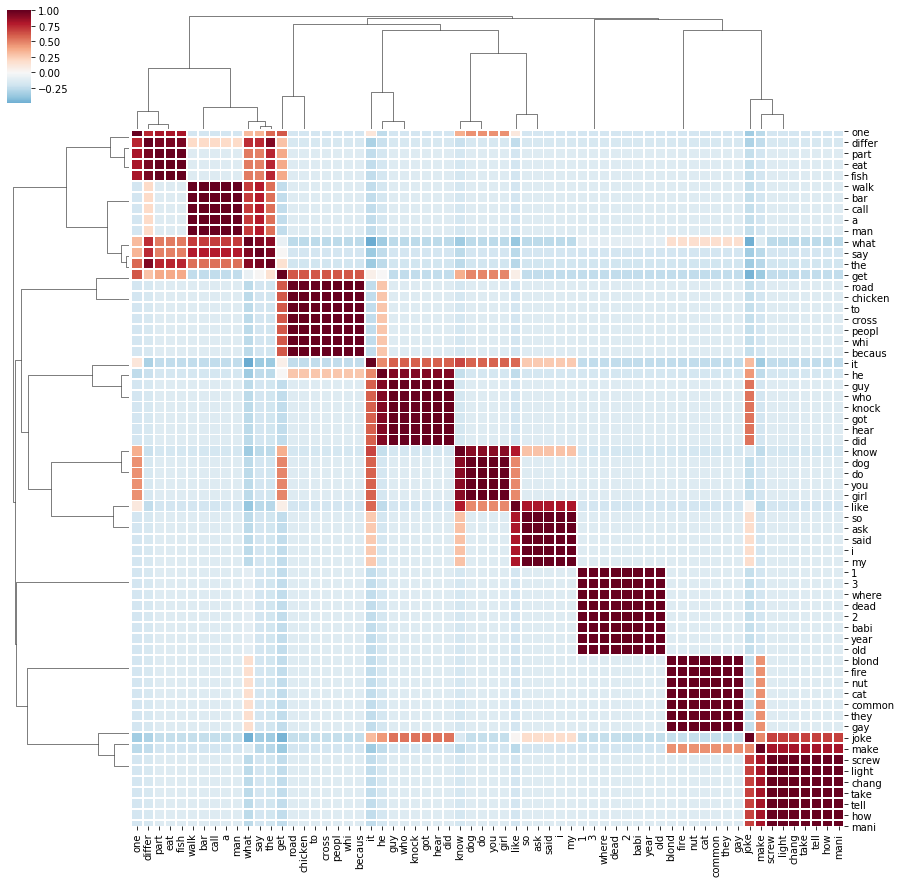

In [91]:
sns.clustermap(df_c_lda.corr(), center=0, cmap="RdBu_r", metric='cosine',
               linewidths=.75, figsize=(15, 15))
plt.show()

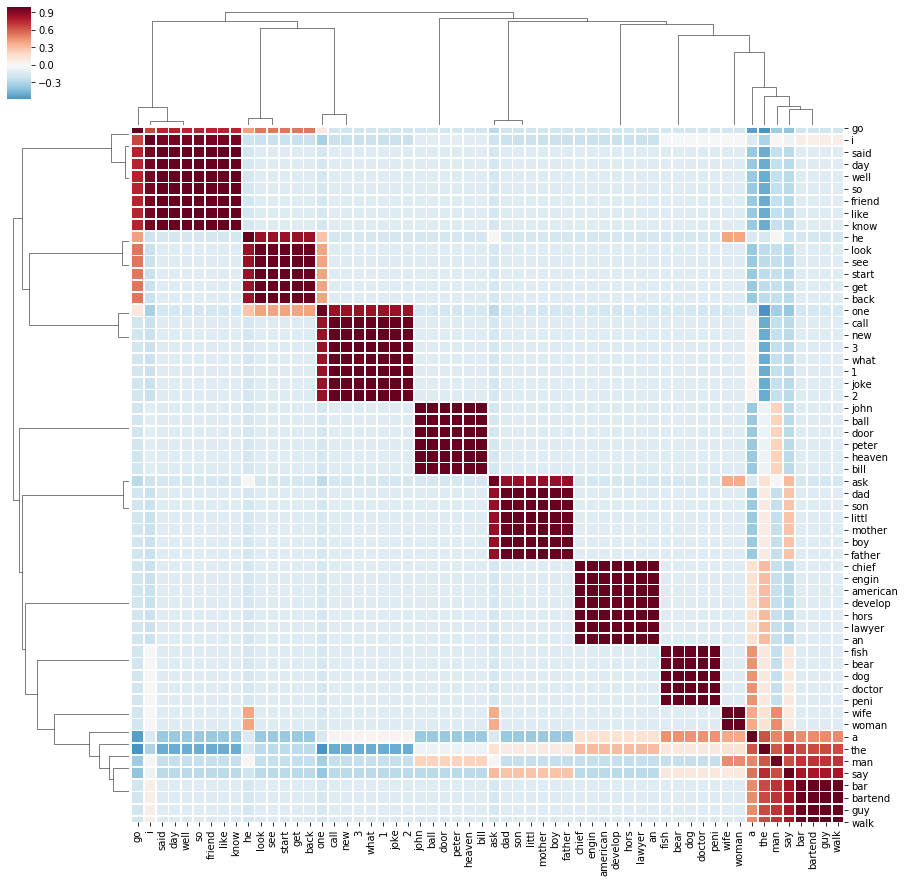

In [92]:
sns.clustermap(df_l_lda.corr(), center=0, cmap="RdBu_r", metric='cosine',
               linewidths=.75, figsize=(15, 15))
plt.show()


## Otimizando a Graça
----

Ate agora escolhemos "aleatoriamente" quantos topicos nosso espaco vetorial teria, vamos tentar otimizar isso.

----

In [94]:
def otimizao(dic, corpus, doc_clean, stop, start=2, step=3, modelo = "lsi"):
    coherence_values = []
    model_list = []
    for number_of_topics in range(start, stop, step):
        if modelo == "lsi":
            model = models.LsiModel(corpus, num_topics=number_of_topics, id2word = dic)
        elif modelo == "lda":
            model = models.ldamodel.LdaModel(corpus, num_topics=number_of_topics, id2word = dic)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dic, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
        
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    return model_list, coherence_values


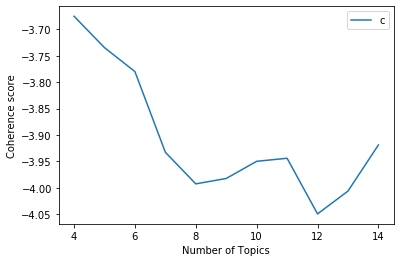

In [95]:
modelos_c,valores_c = otimizao(dic_curto,corpus_tfidf_c,tokens_curtos, 15, 4, 1, "lsi")

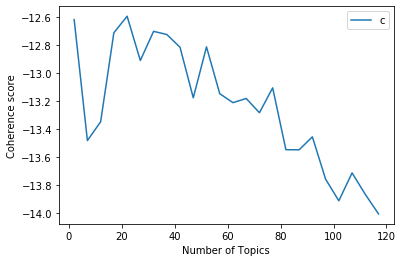

In [98]:
modelos_l,valores_l = otimizao(dic_longo,corpus_tfidf_c,tokens_curtos, 120, 2, 5, "lsi")

## 3- Dando significado às Piadas

----

Usando  biblioteca do gensim, vamos construir uma representação vetorial semantica das nossas piadas com ajuda do word2vec

----

In [104]:
piadas2_limpas = []
c = Counter([])
for texto in tabela.piadas :
    p2limpo = [token.strip(string.punctuation + " "+"").lower() for token in WordPunctTokenizer().tokenize(texto) if token not in swu]
    c.update(p2limpo)
    piadas2_limpas.append(p2limpo)
tokens2 = [[token for token in t if c[token]>1 and token not in [""," ",'“','”','’']] for t in piadas2_limpas]

In [105]:
w2v = models.Word2Vec(piadas2_limpas, min_count = 10, size = 10)

In [106]:
w2v.most_similar(positive=["math"], topn=10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('maths', 0.9425182342529297),
 ('calculus', 0.912060022354126),
 ('basic', 0.9118227958679199),
 ('alphabet', 0.9007551074028015),
 ('teachers', 0.8983732461929321),
 ('fools', 0.8916686773300171),
 ('biology', 0.8877227902412415),
 ('chemistry', 0.8857245445251465),
 ('politics', 0.8831455111503601),
 ('education', 0.8769964575767517)]

----

Uma utilização interessante é procurar similaridade com palavras associadas a piadas direcionadas a um certo grupo ou minoria e ver de quem a internet esta fazendo graça


----

In [114]:
w2v.most_similar(positive=["lightbulbs"], topn=10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('brits', 0.9365121126174927),
 ('christians', 0.929054319858551),
 ('feminists', 0.9282029867172241),
 ('limits', 0.922367513179779),
 ('blacks', 0.9194638133049011),
 ('chromosome', 0.9164672493934631),
 ('germans', 0.9164314270019531),
 ('italians', 0.9152542352676392),
 ('syllables', 0.9139719009399414),
 ('electrons', 0.9138432741165161)]

----

Utilizando agora o fast text comparamos os resutados ao do word2vec

----

In [107]:
fast = FT_gensim(size=10)

In [108]:
fast.build_vocab(sentences=piadas2_limpas)

In [109]:
fast.train(
    sentences=piadas_limpas, epochs=fast.epochs,
    total_examples=fast.corpus_count, total_words=fast.corpus_total_words
)

In [110]:
fast.save('saved_model_gensim')
loaded_model = FT_gensim.load('saved_model_gensim')

In [113]:
fast.most_similar("math")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('maths', 0.9656059741973877),
 ('ada', 0.9449838995933533),
 ('classes', 0.9432960152626038),
 ('alphabetical', 0.9249417185783386),
 ('adapt', 0.9201864004135132),
 ('calculus', 0.9088786244392395),
 ('classics', 0.907306432723999),
 ('classy', 0.9055989384651184),
 ('juans', 0.9053045511245728),
 ('classmates', 0.904349684715271)]

----

De forma curiosa, a mesma tecnica não poderia ser aplicada usando o fast text

----

In [115]:
fast.most_similar(["lightbulbs"], topn=10)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('lightbulb', 0.9956502914428711),
 ('bulbs', 0.9772225618362427),
 ('lightbulbing', 0.976186215877533),
 ('bulb', 0.9679861664772034),
 ('bulbous', 0.9321491122245789),
 ('unscrew', 0.9309293627738953),
 ('kill', 0.9208050966262817),
 ('screw', 0.9082653522491455),
 ('none', 0.9010436534881592),
 ('mlb', 0.9000629186630249)]